Uses tensorforce tensorforce-0.3.0

Took 8 million steps over about a day to warm up. Got 1.6e-4 which is about 25% a month, 25x a year.


In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd
import tensorflow as tf

# util
from collections import Counter
import pdb
import glob
import time
import tempfile
import itertools
from tqdm import tqdm_notebook as tqdm
import datetime

# logging
import logging
logger = log = logging.getLogger(__name__)
# log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf

# solution to bring down version 
from google.protobuf import descriptor_pb2


In [3]:
help(tf)

Help on package tensorflow:

NAME
    tensorflow

DESCRIPTION
    # Copyright 2015 The TensorFlow Authors. All Rights Reserved.
    #
    # Licensed under the Apache License, Version 2.0 (the "License");
    # you may not use this file except in compliance with the License.
    # You may obtain a copy of the License at
    #
    #     http://www.apache.org/licenses/LICENSE-2.0
    #
    # Unless required by applicable law or agreed to in writing, software
    # distributed under the License is distributed on an "AS IS" BASIS,
    # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    # See the License for the specific language governing permissions and
    # limitations under the License.
    # ==============================================================================

PACKAGE CONTENTS
    contrib (package)
    core (package)
    examples (package)
    libtensorflow_framework
    python (package)
    tools (package)

SUBMODULES
    app
    bitwise
    compat

In [4]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding

In [5]:
import os
os.sys.path.append(os.path.abspath('.'))
%reload_ext autoreload
%autoreload 2

In [6]:
# params
window_length = 50
cash_bias = 0.0
batch_size=128
import datetime
ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M')
save_path = './outputs/tensorforce_PPO_crypto-%s' % ts
# save_path = './outputs/tensorforce-PPO/tensorforce_PPO_crypto_20171105_06-50-31'
save_path

'./outputs/tensorforce_PPO_crypto-20180208_17-41'

In [7]:
log_dir = os.path.join('logs', os.path.splitext(os.path.basename(save_path))[0], 'run-' + ts)
try:
    os.makedirs(log_dir)
except OSError:
    pass
log_dir

'logs/tensorforce_PPO_crypto-20180208_17-41/run-20180208_17-41'

# Enviroment

We will wrap out environment so we can modify the inputs, outputs, and attributes for tensorforce.

- tensorforce doesn't like dual outputs so we will concat them
- we need to softmax the weights since tensorforce doesn't do this

In [8]:
from rewave.environment.long_portfolio import PortfolioEnv
from rewave.wrappers import SoftmaxActions, ConcatStates

In [9]:
# tensorforce need us to use this wrapper, passing in a registered gym id
# this lets us pass in an object instead of registering it
from tensorforce.contrib.openai_gym import OpenAIGym
class TFOpenAIGymCust(OpenAIGym):
    def __init__(self, gym_id, gym):
        self.gym_id = gym_id
        self.gym = gym
        self.visualize = True

In [10]:
from datetime import date

start = date(2017, 1, 1)
end = date(2018, 1, 1)
features= ['close', 'high', 'low']
tickers = ['AAPL','A','MSFT','B','C']

env = PortfolioEnv(
    start_date=start,
    end_date=end,
    features_list = features,
    tickers_list=tickers,
    scale=True, 
    trading_cost=0.0025, 
    window_length = window_length,
    output_mode='EIIE',
)
# wrap it in a few wrappers
env = ConcatStates(env)
env = SoftmaxActions(env)
environment = TFOpenAIGymCust('CryptoPortfolioEIIE-v0', env)

env.seed(0)

[0]

In [18]:
envtest = PortfolioEnv(
    start_date=start,
    end_date=end,
    features_list = features,
    tickers_list=tickers,
    scale=True, 
    trading_cost=0.0025, 
    window_length = window_length,
    output_mode='EIIE',
)
envtest.action_space
src = envtest.src

src.reset()
for i in range(0, 20):
    sequence, y1, done = src._step()
    last_close_price = sequence[:, -2, 0]
last_close_price
sequence /= last_close_price[:, np.newaxis, np.newaxis]
#sequence

In [19]:
sequence
np.isnan(src.data).sum()
np.isnan(sequence).sum()
np.nonzero(sequence)
sequence
#sequence.shape

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1

In [20]:
src = envtest.src
history, y1, done = src._step()
history.shape, y1, done

((6, 50, 3), array([1.        , 1.00270088, 1.00645771, 1.01314168, 1.01212717,
        1.00785418]), False)

In [21]:
y1.shape

(6,)

In [22]:
#env = SoftmaxActions(env)


In [23]:
# sanity check out environment is working
state = environment.reset()
step, terminal, reward = environment.execute(env.action_space.sample())
step.shape, terminal, reward

WARN: <class 'rewave.wrappers.softmax_actions.SoftmaxActions'> doesn't implement 'reset' method, which is required for wrappers derived directly from Wrapper. Deprecated default implementation is used.


((6, 50, 3), False, -7.000563693695617e-05)

In [24]:
reward

-7.000563693695617e-05

# Model

Derived from  https://github.com/reinforceio/tensorforce/blob/0d07fadec03f76537a2431e17c51cd759d53b5e9/tensorforce/core/networks/layers.py#L90

Implemented as per CNN version of https://arxiv.org/abs/1706.10059 

In [25]:
from tensorforce.agents import Agent
from tensorforce.core.networks import LayeredNetwork, layers, Network, network

In [26]:
from tensorforce.core.networks import Layer, Conv2d, Nonlinearity
class EIIE(Layer):
    """
    EIIE layer
    """

    def __init__(self,
                 size=20,
                 bias=True,
                 activation='relu',
                 l2_regularization=0.0,
                 l1_regularization=0.0,
                 scope='EIIE',
                 summary_labels=()):
        self.size = size
        # Expectation is broadcast back over advantage values so output is of size 1
        self.conv1 = Conv2d(
            size=3,
            bias=bias,
            stride=(1,1),
            window=(1,3),
            padding='VALID',
            l2_regularization=l2_regularization,
            l1_regularization=l1_regularization,
            summary_labels=summary_labels)
        self.conv2 = Conv2d(
            size=size,
            bias=bias,
            stride=(1,window_length-2-1),
            window=(1,window_length-2-1),
            padding='VALID',
            l2_regularization=l2_regularization,
            l1_regularization=l1_regularization,
            summary_labels=summary_labels)
        self.conv3 = Conv2d(
            size=1,
            bias=bias,
            stride=(1,1),
            window=(1,1),
            l2_regularization=l2_regularization,
            l1_regularization=l1_regularization,
            summary_labels=summary_labels)
        self.nonlinearity = Nonlinearity(
            name=activation, summary_labels=summary_labels)
        self.nonlinearity2 = Nonlinearity(
            name=activation, summary_labels=summary_labels)
        super(EIIE, self).__init__(
            scope=scope, summary_labels=summary_labels)

    def tf_apply(self, x0, update):
        # where window_size=50, actions=4 (giving the 3), data cols=5
        # x0 = (None,3,50,5)
        # x = (None,3,49,5)
        # x = (None,3,1,1)
        # conv1 => (None,3, 47,3)
        # conv2 => (None,3, 1, 20)
        # concat=> (None,3, 1, 21)
        # conv3 => (None,3, 1, 1)
        # concat=> (None,2, 1, 1)

        w0 = x0[:,:,:1,:1]
        x = x0[:,:,1:,:]
        
        x = self.conv1.apply(x, update=update)
        x = self.nonlinearity.apply(x=x, update=update)
        
        x = self.conv2.apply(x, update=update)
        x = self.nonlinearity2.apply(x=x, update=update)
        
        x = tf.concat([x, w0], 3)
        x = self.conv3.apply(x, update=update)
        
        # concat on cash_bias
        cash_bias_int = 0
        # FIXME not sure how to make shape with a flexible size in tensorflow but this works for now
        # cash_bias = tf.ones(shape=(batch_size,1,1,1)) * cash_bias_int
        # cash_bias = x[:,:1,:1,:1]*0 
        # x = tf.concat([cash_bias, x], 1)

        if 'activations' in self.summary_labels:
            summary = tf.summary.histogram(name='activations', values=x)
            self.summaries.append(summary)

        return x

    def tf_regularization_loss(self):
        if super(EIIE, self).tf_regularization_loss() is None:
            losses = list()
        else:
            losses = [super(EIIE, self).tf_regularization_loss()]

        if self.conv1.regularization_loss() is not None:
            losses.append(self.conv1.regularization_loss())
        if self.conv2.regularization_loss() is not None:
            losses.append(self.conv2.regularization_loss())
        if self.conv1.regularization_loss() is not None:
            losses.append(self.conv3.regularization_loss())

        if len(losses) > 0:
            return tf.add_n(inputs=losses)
        else:
            return None

    def get_variables(self, include_non_trainable=False):
        layer_variables = super(EIIE, self).get_variables(
            include_non_trainable=include_non_trainable)

        layer_variables += self.conv1.get_variables(
            include_non_trainable=include_non_trainable)
        layer_variables += self.conv2.get_variables(
            include_non_trainable=include_non_trainable)
        layer_variables += self.conv3.get_variables(
            include_non_trainable=include_non_trainable)

        layer_variables += self.nonlinearity.get_variables(
            include_non_trainable=include_non_trainable)
        layer_variables += self.nonlinearity.get_variables(
            include_non_trainable=include_non_trainable)

        return layer_variables
    
# Add our custom layer
layers['EIIE'] = EIIE

# Network as list of layers
network_spec = [
    dict(type='EIIE', 
         l1_regularization=1e-8,
        l2_regularization=1e-8),
    dict(type='flatten')
]

In [27]:
network_spec

[{'l1_regularization': 1e-08, 'l2_regularization': 1e-08, 'type': 'EIIE'},
 {'type': 'flatten'}]

In [28]:
# also add a custom baseline
from tensorforce.core.baselines import NetworkBaseline
from tensorforce.core.baselines import baselines


class EIIEBaseline(NetworkBaseline):
    """
    CNN baseline (single-state) consisting of convolutional layers followed by dense layers.
    """

    def __init__(self, layers_spec, scope='eiie-baseline', summary_labels=()):
        """
        CNN baseline.
        Args:
            conv_sizes: List of convolutional layer sizes
            dense_sizes: List of dense layer sizes
        """

        super(EIIEBaseline, self).__init__(layers_spec, scope, summary_labels)
        
# Add our custom baseline
baselines['EIIE']=EIIEBaseline

# Agent


In [29]:
environment.gym.observation_space
environment.states

{'shape': (6, 50, 3), 'type': 'float'}

In [30]:
from tensorforce.agents.ppo_agent import PPOAgent

explorations_spec=dict(
    type="epsilon_anneal",
    initial_epsilon=1.0,
    final_epsilon= 0.005,
    timesteps= int(1e5),
    start_timestep=0,
)

# I want to use a gaussian dist instead of beta, we will apply post processing to scale everything
# actions_spec = environment.actions.copy()
# del actions_spec["min_value"]
# del actions_spec["max_value"]
# distributions_spec=dict(action=dict(type='gaussian', mean=0.25, log_stddev=np.log(5e-2)))

# Or just use beta:
actions_spec = environment.actions.copy()
distributions_spec=None

# https://github.com/reinforceio/tensorforce/blob/d823809df746c61471e2cba5832ab051581baf7e/docs/summary_spec.md
summary_spec = dict(directory=log_dir, 
                        steps=50,
                        labels=[
                            'configuration',
                            'gradients_scalar',
                            'regularization',
                            'inputs',
                            'losses',
#                             'variables'
                        ]
                    )
agent = PPOAgent(
    states_spec=environment.states,
    actions_spec=actions_spec,
    network_spec=network_spec,
    batch_size=4096,
    saver_spec = dict(
        directory=save_path, 
        steps=100000, 
#         basename=os.path.basename(save_path)
    ),
    # Agent
    states_preprocessing_spec=None,
    explorations_spec=explorations_spec,
    reward_preprocessing_spec=None,
    # BatchAgent
    keep_last_timestep=True,
    # PPOAgent
    step_optimizer=dict(
        type='adam',
        learning_rate=1e-3
    ),
    optimization_steps=10,
    # Model
    scope='ppo',
    discount=0.99,
    # DistributionModel
    distributions_spec=distributions_spec,
    entropy_regularization=0.01, # 0 and 0.01 in baselines
    # PGModel
    baseline_mode='states',
    baseline=dict(
        type="EIIE",
        layers_spec=network_spec
#         update_batch_size=512,
    ), # string indicating the baseline value function (currently 'linear' or 'mlp').
    baseline_optimizer=dict(type='adam', learning_rate=0.003),
    gae_lambda=0.97,
    # PGLRModel
    likelihood_ratio_clipping=0.2,
    summary_spec=summary_spec,
    distributed_spec=None
)

INFO:tensorflow:Summary name gradients/ppo/optimization/moments/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_1/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_1/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_1/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_1/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_1/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_1/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_1/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_1/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_2/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_2/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_2/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_2/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_2/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_2/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_2/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_2/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_3/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_3/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_3/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_3/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_3/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_3/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_3/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_3/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_4/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_4/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_4/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_4/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_4/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_4/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_4/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_4/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_5/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_5/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_5/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_5/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_5/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_5/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_5/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_5/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_6/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_6/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_6/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_6/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_6/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_6/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_6/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_6/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_7/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_7/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_7/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_7/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_7/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_7/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_7/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_7/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_8/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_8/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_8/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_8/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_8/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_8/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_8/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_8/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_9/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_9/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_9/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_9/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_9/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_9/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_9/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_9/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_10/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_10/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_10/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_10/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_10/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_10/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_10/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_10/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_11/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_11/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_11/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_11/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_11/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_11/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_11/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_11/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_12/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_12/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_12/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_12/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_12/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_12/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_12/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_12/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_13/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_13/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_13/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_13/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_13/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_13/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_13/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_13/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_14/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_14/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_14/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_14/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_14/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_14/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_14/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_14/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_15/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_15/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_15/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_15/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_15/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_15/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_15/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_15/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_16/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_16/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_16/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_16/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_16/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_16/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_16/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_16/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_17/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_17/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_17/Squeeze_1:0/mean is illegal; using gradients/ppo/optimization/moments_17/Squeeze_1_0/mean instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_17/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_17/Squeeze_1_0/variance instead.


INFO:tensorflow:Summary name gradients/ppo/optimization/moments_17/Squeeze_1:0/variance is illegal; using gradients/ppo/optimization/moments_17/Squeeze_1_0/variance instead.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 0 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


# Train

## Callbacks

In [31]:
from rewave.callbacks.tensorforce import EpisodeFinishedTQDM, EpisodeFinished
from rewave.tools.util import MDD, sharpe

## Train

In [32]:
from tensorforce.execution import Runner
runner = Runner(agent=agent, environment=environment)

HBox(children=(IntProgress(value=0, max=12000000), HTML(value='')))

TensorBoardLogger started. Run `tensorboard --logdir=/Users/raphaelbiojout/code/rewave/logs/tensorforce_PPO_crypto-20180208_17-41` to visualize
ep reward:  0.00004718 [-0.00017320,  0.00028265], portfolio_value:  1.0434 mdd=-1.38% sharpe=2.1673, expl= 0.00% eps=1000 weights={'C': 0.1679999977350235, 'AAPL': 0.1679999977350235, 'B': 0.1679999977350235, 'cash': 0.1598999947309494, 'MSFT': 0.1679999977350235, 'A': 0.1679999977350235}


<IPython.core.display.Javascript object>


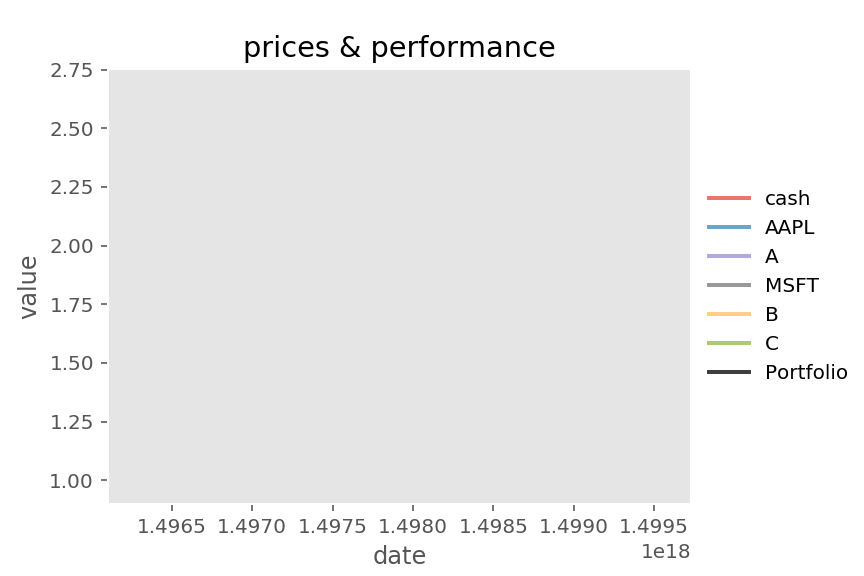

<IPython.core.display.Javascript object>


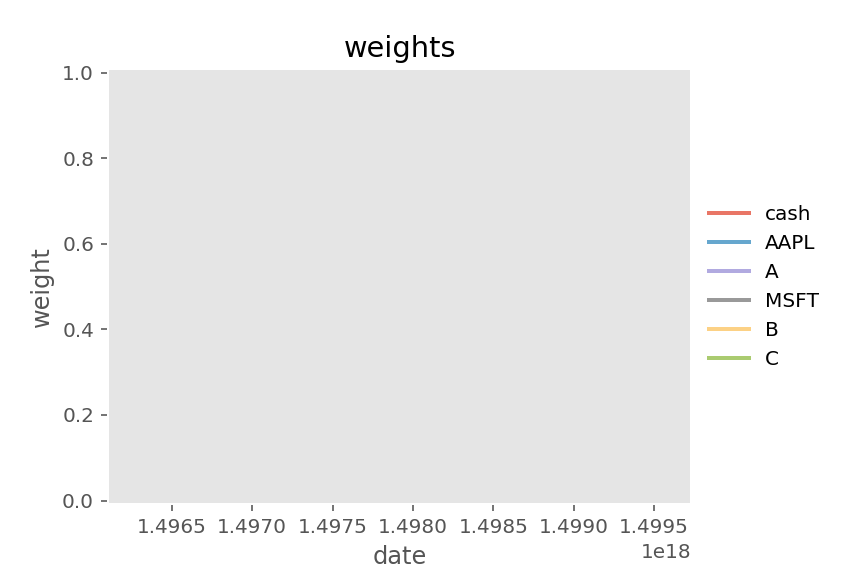

<IPython.core.display.Javascript object>


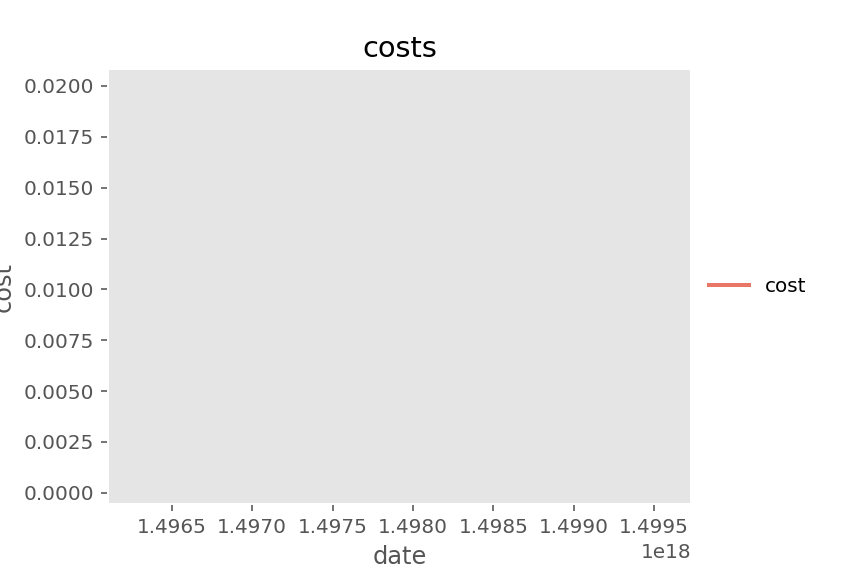

ep reward:  0.00004005 [-0.00029465,  0.00032315], portfolio_value:  1.0367 mdd=-1.16% sharpe=1.6498, expl= 0.00% eps=2000 weights={'C': 0.14110000431537628, 'AAPL': 0.17100000381469727, 'B': 0.149399995803833, 'cash': 0.14970000088214874, 'MSFT': 0.2305999994277954, 'A': 0.15809999406337738}
ep reward:  0.00000989 [-0.00041386,  0.00042096], portfolio_value:  1.0089 mdd=-2.16% sharpe=0.2804, expl= 0.00% eps=3000 weights={'C': 0.17829999327659607, 'AAPL': 0.11829999834299088, 'B': 0.13819999992847443, 'cash': 0.2556999921798706, 'MSFT': 0.17720000445842743, 'A': 0.1324000060558319}
INFO:tensorflow:Saving checkpoints for 100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


INFO:tensorflow:Saving checkpoints for 100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004316 [-0.00026143,  0.00033886], portfolio_value:  1.0396 mdd=-1.82% sharpe=1.6356, expl= 0.00% eps=4000 weights={'C': 0.09799999743700027, 'AAPL': 0.1152999997138977, 'B': 0.1842000037431717, 'cash': 0.23720000684261322, 'MSFT': 0.1712000072002411, 'A': 0.19419999420642853}
ep reward:  0.00004087 [-0.00080524,  0.00030135], portfolio_value:  1.0375 mdd=-1.45% sharpe=1.1444, expl= 0.00% eps=5000 weights={'C': 0.2078000009059906, 'AAPL': 0.19349999725818634, 'B': 0.14830000698566437, 'cash': 0.1290999948978424, 'MSFT': 0.11640000343322754, 'A': 0.20499999821186066}
ep reward:  0.00004962 [-0.00082046,  0.00042282], portfolio_value:  1.0457 mdd=-3.80% sharpe=1.3005, expl= 0.00% eps=6000 weights={'C': 0.1738000065088272, 'AAPL': 0.10350000113248825, 'B': 0.22990000247955322, 'cash': 0.1396999955177307, 'MSFT': 0.17159999907016754, 'A': 0.18140000104904175}
INFO:tensorflow:Saving checkpoints for 200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


INFO:tensorflow:Saving checkpoints for 200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00015543 [-0.00277027,  0.00717587], portfolio_value:  1.1501 mdd=-26.28% sharpe=0.6655, expl= 0.00% eps=7000 weights={'C': 0.12189999967813492, 'AAPL': 0.1565999984741211, 'B': 0.1565999984741211, 'cash': 0.14800000190734863, 'MSFT': 0.1867000013589859, 'A': 0.23029999434947968}
ep reward:  0.00002448 [-0.00066990,  0.00038549], portfolio_value:  1.0223 mdd=-1.90% sharpe=0.6176, expl= 0.00% eps=8000 weights={'C': 0.14990000426769257, 'AAPL': 0.11079999804496765, 'B': 0.2395000010728836, 'cash': 0.12099999934434891, 'MSFT': 0.1673000007867813, 'A': 0.21150000393390656}
ep reward:  0.00003093 [-0.00028794,  0.00036993], portfolio_value:  1.0282 mdd=-1.99% sharpe=1.0364, expl= 0.00% eps=9000 weights={'C': 0.14890000224113464, 'AAPL': 0.21150000393390656, 'B': 0.1257999986410141, 'cash': 0.12880000472068787, 'MSFT': 0.14830000698566437, 'A': 0.23659999668598175}
ep reward:  0.00006137 [-0.00082290,  0.00044557], portfolio_value:  1.0568 mdd=-3.88% sharpe=1.5908, expl= 0.00% 

INFO:tensorflow:Saving checkpoints for 300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004395 [-0.00020375,  0.00047781], portfolio_value:  1.0403 mdd=-1.67% sharpe=1.4583, expl= 0.00% eps=11000 weights={'C': 0.1995999962091446, 'AAPL': 0.18000000715255737, 'B': 0.131400004029274, 'cash': 0.1793999969959259, 'MSFT': 0.11659999936819077, 'A': 0.19300000369548798}
ep reward:  0.00000776 [-0.00028965,  0.00044140], portfolio_value:  1.0070 mdd=-2.22% sharpe=0.2376, expl= 0.00% eps=12000 weights={'C': 0.1453000009059906, 'AAPL': 0.20489999651908875, 'B': 0.11729999631643295, 'cash': 0.2011999934911728, 'MSFT': 0.1062999963760376, 'A': 0.2249000072479248}
ep reward: -0.00001723 [-0.00028104,  0.00046066], portfolio_value:  0.9846 mdd=0.00% sharpe=-0.4831, expl= 0.00% eps=13000 weights={'C': 0.14959999918937683, 'AAPL': 0.16279999911785126, 'B': 0.13609999418258667, 'cash': 0.1356000006198883, 'MSFT': 0.23100000619888306, 'A': 0.18490000069141388}
INFO:tensorflow:Saving checkpoints for 400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


INFO:tensorflow:Saving checkpoints for 400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000879 [-0.00078695,  0.00040792], portfolio_value:  1.0079 mdd=-2.44% sharpe=0.2417, expl= 0.00% eps=14000 weights={'C': 0.1590999960899353, 'AAPL': 0.17470000684261322, 'B': 0.1265999972820282, 'cash': 0.17020000517368317, 'MSFT': 0.1979999989271164, 'A': 0.17139999568462372}
ep reward:  0.00001316 [-0.00056364,  0.00039458], portfolio_value:  1.0119 mdd=-2.03% sharpe=0.3980, expl= 0.00% eps=15000 weights={'C': 0.16359999775886536, 'AAPL': 0.1712999939918518, 'B': 0.19419999420642853, 'cash': 0.2134999930858612, 'MSFT': 0.13500000536441803, 'A': 0.12219999730587006}
ep reward:  0.00004024 [-0.00027865,  0.00043315], portfolio_value:  1.0369 mdd=-2.16% sharpe=1.4027, expl= 0.00% eps=16000 weights={'C': 0.1436000019311905, 'AAPL': 0.23960000276565552, 'B': 0.11289999634027481, 'cash': 0.21199999749660492, 'MSFT': 0.18780000507831573, 'A': 0.10409999638795853}
ep reward:  0.00001030 [-0.00031905,  0.00038527], portfolio_value:  1.0093 mdd=-2.03% sharpe=0.3247, expl= 0.00

INFO:tensorflow:Saving checkpoints for 500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000963 [-0.00042188,  0.00042334], portfolio_value:  0.9914 mdd=-2.57% sharpe=-0.2464, expl= 0.00% eps=18000 weights={'C': 0.14010000228881836, 'AAPL': 0.1396999955177307, 'B': 0.12800000607967377, 'cash': 0.15700000524520874, 'MSFT': 0.27090001106262207, 'A': 0.16429999470710754}
ep reward:  0.00006578 [-0.00433726,  0.00576221], portfolio_value:  1.0610 mdd=-20.94% sharpe=0.3698, expl= 0.00% eps=19000 weights={'C': 0.16459999978542328, 'AAPL': 0.18449999392032623, 'B': 0.1362999975681305, 'cash': 0.23929999768733978, 'MSFT': 0.1388999968767166, 'A': 0.1363999992609024}
ep reward:  0.00004163 [-0.00028823,  0.00035835], portfolio_value:  1.0382 mdd=-1.96% sharpe=1.4921, expl= 0.00% eps=20000 weights={'C': 0.1242000013589859, 'AAPL': 0.16590000689029694, 'B': 0.19249999523162842, 'cash': 0.16699999570846558, 'MSFT': 0.22089999914169312, 'A': 0.12950000166893005}
INFO:tensorflow:Saving checkpoints for 600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt

INFO:tensorflow:Saving checkpoints for 600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00002159 [-0.00038208,  0.00041448], portfolio_value:  0.9808 mdd=-2.42% sharpe=-0.6718, expl= 0.00% eps=21000 weights={'C': 0.14350000023841858, 'AAPL': 0.19660000503063202, 'B': 0.17059999704360962, 'cash': 0.1590999960899353, 'MSFT': 0.19740000367164612, 'A': 0.13279999792575836}
ep reward: -0.00002076 [-0.00025463,  0.00021843], portfolio_value:  0.9815 mdd=-1.43% sharpe=-0.9680, expl= 0.00% eps=22000 weights={'C': 0.21709999442100525, 'AAPL': 0.2126999944448471, 'B': 0.11699999868869781, 'cash': 0.20880000293254852, 'MSFT': 0.11990000307559967, 'A': 0.12449999898672104}
ep reward:  0.00002716 [-0.00026337,  0.00038136], portfolio_value:  1.0247 mdd=-1.95% sharpe=0.9585, expl= 0.00% eps=23000 weights={'C': 0.14730000495910645, 'AAPL': 0.18440000712871552, 'B': 0.13339999318122864, 'cash': 0.19359999895095825, 'MSFT': 0.16380000114440918, 'A': 0.17749999463558197}
ep reward:  0.00009025 [-0.00342753,  0.00535662], portfolio_value:  1.0846 mdd=-19.57% sharpe=0.4977, exp

INFO:tensorflow:Saving checkpoints for 700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001469 [-0.00031853,  0.00041661], portfolio_value:  1.0133 mdd=-2.23% sharpe=0.4775, expl= 0.00% eps=25000 weights={'C': 0.17260000109672546, 'AAPL': 0.19740000367164612, 'B': 0.09619999676942825, 'cash': 0.21660000085830688, 'MSFT': 0.17489999532699585, 'A': 0.14229999482631683}
ep reward:  0.00002303 [-0.00051482,  0.00043268], portfolio_value:  1.0209 mdd=-2.08% sharpe=0.6960, expl= 0.00% eps=26000 weights={'C': 0.1712000072002411, 'AAPL': 0.19040000438690186, 'B': 0.13359999656677246, 'cash': 0.1468999981880188, 'MSFT': 0.181099995970726, 'A': 0.17679999768733978}
ep reward: -0.00001387 [-0.00043084,  0.00047304], portfolio_value:  0.9876 mdd=-2.38% sharpe=-0.3420, expl= 0.00% eps=27000 weights={'C': 0.1477999985218048, 'AAPL': 0.1565999984741211, 'B': 0.1454000025987625, 'cash': 0.18299999833106995, 'MSFT': 0.18250000476837158, 'A': 0.18469999730587006}
INFO:tensorflow:Saving checkpoints for 800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


INFO:tensorflow:Saving checkpoints for 800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00005068 [-0.00073482,  0.00035879], portfolio_value:  1.0467 mdd=-3.34% sharpe=1.4341, expl= 0.00% eps=28000 weights={'C': 0.20059999823570251, 'AAPL': 0.1826000064611435, 'B': 0.1680999994277954, 'cash': 0.16369999945163727, 'MSFT': 0.14100000262260437, 'A': 0.14399999380111694}
ep reward:  0.00012450 [-0.00510165,  0.00919854], portfolio_value:  1.1186 mdd=-34.15% sharpe=0.4754, expl= 0.00% eps=29000 weights={'C': 0.1574999988079071, 'AAPL': 0.12680000066757202, 'B': 0.15049999952316284, 'cash': 0.1800999939441681, 'MSFT': 0.18039999902248383, 'A': 0.2046000063419342}
ep reward: -0.00002103 [-0.00022473,  0.00033860], portfolio_value:  0.9813 mdd=-1.31% sharpe=-0.8090, expl= 0.00% eps=30000 weights={'C': 0.1754000037908554, 'AAPL': 0.17430000007152557, 'B': 0.17710000276565552, 'cash': 0.17020000517368317, 'MSFT': 0.15710000693798065, 'A': 0.1459999978542328}
ep reward:  0.00004244 [-0.00027430,  0.00037917], portfolio_value:  1.0389 mdd=-1.98% sharpe=1.5015, expl= 0.0

INFO:tensorflow:Saving checkpoints for 900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000941 [-0.00031813,  0.00045457], portfolio_value:  1.0085 mdd=-2.30% sharpe=0.2892, expl= 0.00% eps=32000 weights={'C': 0.22089999914169312, 'AAPL': 0.121799997985363, 'B': 0.1703999936580658, 'cash': 0.18690000474452972, 'MSFT': 0.15469999611377716, 'A': 0.1451999992132187}
ep reward:  0.00002875 [-0.00028155,  0.00033249], portfolio_value:  1.0262 mdd=-1.86% sharpe=0.9947, expl= 0.00% eps=33000 weights={'C': 0.11840000003576279, 'AAPL': 0.1671999990940094, 'B': 0.19550000131130219, 'cash': 0.14560000598430634, 'MSFT': 0.2542000114917755, 'A': 0.11909999698400497}
ep reward:  0.00002593 [-0.00026005,  0.00030891], portfolio_value:  1.0236 mdd=-1.43% sharpe=1.0698, expl= 0.00% eps=34000 weights={'C': 0.125900000333786, 'AAPL': 0.14820000529289246, 'B': 0.14190000295639038, 'cash': 0.2249000072479248, 'MSFT': 0.13359999656677246, 'A': 0.22529999911785126}
INFO:tensorflow:Saving checkpoints for 1000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000613 [-0.00031040,  0.00044637], portfolio_value:  1.0055 mdd=-2.30% sharpe=0.2001, expl= 0.00% eps=35000 weights={'C': 0.11289999634027481, 'AAPL': 0.2280000001192093, 'B': 0.1315000057220459, 'cash': 0.28949999809265137, 'MSFT': 0.10989999771118164, 'A': 0.1281999945640564}
ep reward:  0.00011459 [-0.00305973,  0.00611648], portfolio_value:  1.1086 mdd=-22.40% sharpe=0.5680, expl= 0.00% eps=36000 weights={'C': 0.15049999952316284, 'AAPL': 0.18199999630451202, 'B': 0.13459999859333038, 'cash': 0.14630000293254852, 'MSFT': 0.2222999930381775, 'A': 0.16449999809265137}
ep reward:  0.00004071 [-0.00026382,  0.00047996], portfolio_value:  1.0373 mdd=-1.51% sharpe=1.2489, expl= 0.00% eps=37000 weights={'C': 0.11349999904632568, 'AAPL': 0.2240999937057495, 'B': 0.12049999833106995, 'cash': 0.15680000185966492, 'MSFT': 0.14239999651908875, 'A': 0.2425999939441681}
INFO:tensorflow:Saving checkpoints for 1100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.

INFO:tensorflow:Saving checkpoints for 1100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000135 [-0.00054166,  0.00038923], portfolio_value:  1.0012 mdd=-2.01% sharpe=0.0562, expl= 0.00% eps=38000 weights={'C': 0.11230000108480453, 'AAPL': 0.2206999957561493, 'B': 0.2425999939441681, 'cash': 0.12449999898672104, 'MSFT': 0.10989999771118164, 'A': 0.19009999930858612}
ep reward:  0.00003274 [-0.00084948,  0.00045002], portfolio_value:  1.0299 mdd=-1.94% sharpe=0.8753, expl= 0.00% eps=39000 weights={'C': 0.19269999861717224, 'AAPL': 0.13680000603199005, 'B': 0.11860000342130661, 'cash': 0.15700000524520874, 'MSFT': 0.2605000138282776, 'A': 0.13439999520778656}
ep reward: -0.00001090 [-0.00028476,  0.00039685], portfolio_value:  0.9902 mdd=-2.07% sharpe=-0.3256, expl= 0.00% eps=40000 weights={'C': 0.2329999953508377, 'AAPL': 0.14900000393390656, 'B': 0.26159998774528503, 'cash': 0.14470000565052032, 'MSFT': 0.1046999990940094, 'A': 0.10689999908208847}
ep reward:  0.00025374 [-0.00061757,  0.00691830], portfolio_value:  1.2565 mdd=-25.37% sharpe=1.1015, expl= 0

INFO:tensorflow:Saving checkpoints for 1200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001547 [-0.00026119,  0.00030912], portfolio_value:  1.0140 mdd=-1.49% sharpe=0.6750, expl= 0.00% eps=42000 weights={'C': 0.11869999766349792, 'AAPL': 0.2287999987602234, 'B': 0.18860000371932983, 'cash': 0.17509999871253967, 'MSFT': 0.12690000236034393, 'A': 0.16189999878406525}
ep reward:  0.00009655 [-0.00354366,  0.00616988], portfolio_value:  1.0908 mdd=-22.56% sharpe=0.4863, expl= 0.00% eps=43000 weights={'C': 0.20499999821186066, 'AAPL': 0.19990000128746033, 'B': 0.11379999667406082, 'cash': 0.17890000343322754, 'MSFT': 0.17579999566078186, 'A': 0.1264999955892563}
ep reward:  0.00001391 [-0.00052107,  0.00041972], portfolio_value:  1.0126 mdd=-2.14% sharpe=0.4106, expl= 0.00% eps=44000 weights={'C': 0.10760000348091125, 'AAPL': 0.21289999783039093, 'B': 0.21199999749660492, 'cash': 0.20909999310970306, 'MSFT': 0.16509999334812164, 'A': 0.0934000015258789}
INFO:tensorflow:Saving checkpoints for 1300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ck

INFO:tensorflow:Saving checkpoints for 1300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00013883 [-0.00361695,  0.00718377], portfolio_value:  1.1331 mdd=-26.77% sharpe=0.5949, expl= 0.00% eps=45000 weights={'C': 0.11490000039339066, 'AAPL': 0.19550000131130219, 'B': 0.22840000689029694, 'cash': 0.1881999969482422, 'MSFT': 0.11190000176429749, 'A': 0.16110000014305115}
ep reward: -0.00001380 [-0.00042069,  0.00037129], portfolio_value:  0.9877 mdd=-2.40% sharpe=-0.3869, expl= 0.00% eps=46000 weights={'C': 0.19439999759197235, 'AAPL': 0.2011999934911728, 'B': 0.12950000166893005, 'cash': 0.1429000049829483, 'MSFT': 0.15729999542236328, 'A': 0.17470000684261322}
ep reward:  0.00002243 [-0.00025345,  0.00030399], portfolio_value:  1.0204 mdd=-1.64% sharpe=0.8681, expl= 0.00% eps=47000 weights={'C': 0.186599999666214, 'AAPL': 0.17399999499320984, 'B': 0.14149999618530273, 'cash': 0.21160000562667847, 'MSFT': 0.15530000627040863, 'A': 0.13099999725818634}
ep reward:  0.00012082 [-0.00417811,  0.00777574], portfolio_value:  1.1149 mdd=-28.84% sharpe=0.5065, expl= 

INFO:tensorflow:Saving checkpoints for 1400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00012297 [-0.00314889,  0.00688193], portfolio_value:  1.1170 mdd=-25.20% sharpe=0.5592, expl= 0.00% eps=49000 weights={'C': 0.15189999341964722, 'AAPL': 0.22169999778270721, 'B': 0.13770000636577606, 'cash': 0.16859999299049377, 'MSFT': 0.18199999630451202, 'A': 0.1379999965429306}
ep reward:  0.00001322 [-0.00031580,  0.00035499], portfolio_value:  1.0120 mdd=-2.03% sharpe=0.4817, expl= 0.00% eps=50000 weights={'C': 0.22930000722408295, 'AAPL': 0.125900000333786, 'B': 0.1340000033378601, 'cash': 0.12439999729394913, 'MSFT': 0.21240000426769257, 'A': 0.17389999330043793}
ep reward:  0.00001816 [-0.00026266,  0.00027646], portfolio_value:  1.0165 mdd=-1.63% sharpe=0.7627, expl= 0.00% eps=51000 weights={'C': 0.19869999587535858, 'AAPL': 0.15610000491142273, 'B': 0.12250000238418579, 'cash': 0.19120000302791595, 'MSFT': 0.1421000063419342, 'A': 0.18940000236034393}
INFO:tensorflow:Saving checkpoints for 1500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt

INFO:tensorflow:Saving checkpoints for 1500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00001343 [-0.00027260,  0.00029555], portfolio_value:  0.9880 mdd=-1.26% sharpe=-0.4697, expl= 0.00% eps=52000 weights={'C': 0.2371000051498413, 'AAPL': 0.18060000240802765, 'B': 0.11940000206232071, 'cash': 0.1720000058412552, 'MSFT': 0.14329999685287476, 'A': 0.14749999344348907}
ep reward: -0.00001615 [-0.00049788,  0.00050754], portfolio_value:  0.9856 mdd=-2.38% sharpe=-0.3974, expl= 0.00% eps=53000 weights={'C': 0.16189999878406525, 'AAPL': 0.13230000436306, 'B': 0.14839999377727509, 'cash': 0.22089999914169312, 'MSFT': 0.14059999585151672, 'A': 0.19589999318122864}
ep reward:  0.00019671 [-0.00344365,  0.00886387], portfolio_value:  1.1937 mdd=-32.89% sharpe=0.6935, expl= 0.00% eps=54000 weights={'C': 0.2214999943971634, 'AAPL': 0.14390000700950623, 'B': 0.15710000693798065, 'cash': 0.19509999454021454, 'MSFT': 0.13040000200271606, 'A': 0.15199999511241913}
ep reward: -0.00000549 [-0.00081530,  0.00042576], portfolio_value:  0.9951 mdd=-2.19% sharpe=-0.1066, expl= 

INFO:tensorflow:Saving checkpoints for 1600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003652 [-0.00020401,  0.00035761], portfolio_value:  1.0334 mdd=-1.70% sharpe=1.4781, expl= 0.00% eps=56000 weights={'C': 0.19210000336170197, 'AAPL': 0.19670000672340393, 'B': 0.1736000031232834, 'cash': 0.19220000505447388, 'MSFT': 0.12710000574588776, 'A': 0.11819999665021896}
ep reward: -0.00000362 [-0.00044989,  0.00049295], portfolio_value:  0.9967 mdd=-2.10% sharpe=-0.0812, expl= 0.00% eps=57000 weights={'C': 0.219200000166893, 'AAPL': 0.13750000298023224, 'B': 0.12489999830722809, 'cash': 0.16609999537467957, 'MSFT': 0.14429999887943268, 'A': 0.20810000598430634}
ep reward:  0.00001787 [-0.00028286,  0.00048108], portfolio_value:  1.0162 mdd=-2.32% sharpe=0.5749, expl= 0.00% eps=58000 weights={'C': 0.11680000275373459, 'AAPL': 0.17550000548362732, 'B': 0.18440000712871552, 'cash': 0.23100000619888306, 'MSFT': 0.11079999804496765, 'A': 0.18140000104904175}
INFO:tensorflow:Saving checkpoints for 1700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ck

INFO:tensorflow:Saving checkpoints for 1700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000159 [-0.00031062,  0.00049052], portfolio_value:  0.9986 mdd=-2.21% sharpe=-0.0331, expl= 0.00% eps=59000 weights={'C': 0.12479999661445618, 'AAPL': 0.16099999845027924, 'B': 0.2046000063419342, 'cash': 0.18889999389648438, 'MSFT': 0.14910000562667847, 'A': 0.17170000076293945}
ep reward:  0.00004320 [-0.00085515,  0.00033937], portfolio_value:  1.0396 mdd=-3.65% sharpe=1.1624, expl= 0.00% eps=60000 weights={'C': 0.13899999856948853, 'AAPL': 0.12540000677108765, 'B': 0.20890000462532043, 'cash': 0.16439999639987946, 'MSFT': 0.23100000619888306, 'A': 0.13130000233650208}
ep reward:  0.00000253 [-0.00087973,  0.00045350], portfolio_value:  1.0023 mdd=-2.17% sharpe=0.0812, expl= 0.00% eps=61000 weights={'C': 0.18649999797344208, 'AAPL': 0.13529999554157257, 'B': 0.11169999837875366, 'cash': 0.25589999556541443, 'MSFT': 0.19449999928474426, 'A': 0.11620000004768372}
ep reward: -0.00000973 [-0.00028522,  0.00031215], portfolio_value:  0.9913 mdd=0.00% sharpe=-0.3497, expl

INFO:tensorflow:Saving checkpoints for 1800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00019669 [-0.00280241,  0.00874936], portfolio_value:  1.1937 mdd=-32.73% sharpe=0.7051, expl= 0.00% eps=63000 weights={'C': 0.09160000085830688, 'AAPL': 0.1607999950647354, 'B': 0.2282000035047531, 'cash': 0.13169999420642853, 'MSFT': 0.16300000250339508, 'A': 0.2248000055551529}
ep reward:  0.00000152 [-0.00070982,  0.00043842], portfolio_value:  1.0014 mdd=-2.18% sharpe=0.0549, expl= 0.00% eps=64000 weights={'C': 0.13850000500679016, 'AAPL': 0.25209999084472656, 'B': 0.23510000109672546, 'cash': 0.1477999985218048, 'MSFT': 0.11029999703168869, 'A': 0.11630000174045563}
ep reward: -0.00001199 [-0.00031884,  0.00032478], portfolio_value:  0.9893 mdd=-1.95% sharpe=-0.3409, expl= 0.00% eps=65000 weights={'C': 0.2329999953508377, 'AAPL': 0.11500000208616257, 'B': 0.15219999849796295, 'cash': 0.11680000275373459, 'MSFT': 0.19179999828338623, 'A': 0.19120000302791595}
INFO:tensorflow:Saving checkpoints for 1900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckp

INFO:tensorflow:Saving checkpoints for 1900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000650 [-0.00037243,  0.00044449], portfolio_value:  1.0059 mdd=-2.29% sharpe=0.1902, expl= 0.00% eps=66000 weights={'C': 0.15760000050067902, 'AAPL': 0.19169999659061432, 'B': 0.1177000030875206, 'cash': 0.09210000187158585, 'MSFT': 0.2222999930381775, 'A': 0.21850000321865082}
ep reward:  0.00000327 [-0.00035727,  0.00038505], portfolio_value:  1.0029 mdd=-2.07% sharpe=0.1065, expl= 0.00% eps=67000 weights={'C': 0.16990000009536743, 'AAPL': 0.15160000324249268, 'B': 0.18029999732971191, 'cash': 0.12070000171661377, 'MSFT': 0.23800000548362732, 'A': 0.13950000703334808}
ep reward:  0.00006098 [-0.00078333,  0.00046300], portfolio_value:  1.0564 mdd=-3.81% sharpe=1.5954, expl= 0.00% eps=68000 weights={'C': 0.11580000072717667, 'AAPL': 0.18289999663829803, 'B': 0.2797999978065491, 'cash': 0.13920000195503235, 'MSFT': 0.14869999885559082, 'A': 0.13349999487400055}
INFO:tensorflow:Saving checkpoints for 2000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckp

INFO:tensorflow:Saving checkpoints for 2000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003320 [-0.00080639,  0.00045184], portfolio_value:  1.0303 mdd=-3.85% sharpe=0.8215, expl= 0.00% eps=69000 weights={'C': 0.18230000138282776, 'AAPL': 0.13689999282360077, 'B': 0.22280000150203705, 'cash': 0.1551000028848648, 'MSFT': 0.16869999468326569, 'A': 0.13410000503063202}
ep reward: -0.00001012 [-0.00024565,  0.00029166], portfolio_value:  0.9909 mdd=0.00% sharpe=-0.3884, expl= 0.00% eps=70000 weights={'C': 0.11779999732971191, 'AAPL': 0.25360000133514404, 'B': 0.1648000031709671, 'cash': 0.181099995970726, 'MSFT': 0.15449999272823334, 'A': 0.1281999945640564}
ep reward:  0.00025533 [-0.00229713,  0.00997493], portfolio_value:  1.2583 mdd=-37.47% sharpe=0.7993, expl= 0.00% eps=71000 weights={'C': 0.12200000137090683, 'AAPL': 0.15649999678134918, 'B': 0.12439999729394913, 'cash': 0.23899999260902405, 'MSFT': 0.1421000063419342, 'A': 0.2160000056028366}
ep reward:  0.00002979 [-0.00079289,  0.00044202], portfolio_value:  1.0272 mdd=-3.77% sharpe=0.7407, expl= 0.00

INFO:tensorflow:Saving checkpoints for 2100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004375 [-0.00024524,  0.00036603], portfolio_value:  1.0402 mdd=-1.83% sharpe=1.5742, expl= 0.00% eps=73000 weights={'C': 0.20069999992847443, 'AAPL': 0.15760000050067902, 'B': 0.14980000257492065, 'cash': 0.11299999803304672, 'MSFT': 0.19699999690055847, 'A': 0.1818999946117401}
ep reward:  0.00009907 [-0.00445138,  0.00724545], portfolio_value:  1.0933 mdd=-26.59% sharpe=0.4510, expl= 0.00% eps=74000 weights={'C': 0.13439999520778656, 'AAPL': 0.1965000033378601, 'B': 0.11649999767541885, 'cash': 0.24070000648498535, 'MSFT': 0.15760000050067902, 'A': 0.1543000042438507}
ep reward:  0.00001708 [-0.00555889,  0.00607745], portfolio_value:  1.0155 mdd=-22.16% sharpe=0.1840, expl= 0.00% eps=75000 weights={'C': 0.1598999947309494, 'AAPL': 0.26109999418258667, 'B': 0.10849999636411667, 'cash': 0.149399995803833, 'MSFT': 0.12999999523162842, 'A': 0.19120000302791595}
INFO:tensorflow:Saving checkpoints for 2200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt

INFO:tensorflow:Saving checkpoints for 2200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00005029 [-0.00050417,  0.00029557], portfolio_value:  0.9558 mdd=-2.43% sharpe=-1.4915, expl= 0.00% eps=76000 weights={'C': 0.2402999997138977, 'AAPL': 0.11100000143051147, 'B': 0.19709999859333038, 'cash': 0.1891999989748001, 'MSFT': 0.11129999905824661, 'A': 0.15109999477863312}
ep reward: -0.00003284 [-0.00040442,  0.00033888], portfolio_value:  0.9709 mdd=-2.25% sharpe=-1.0174, expl= 0.00% eps=77000 weights={'C': 0.0997999981045723, 'AAPL': 0.18610000610351562, 'B': 0.22830000519752502, 'cash': 0.18529999256134033, 'MSFT': 0.16040000319480896, 'A': 0.14000000059604645}
ep reward:  0.00001336 [-0.00028773,  0.00039377], portfolio_value:  1.0121 mdd=-2.00% sharpe=0.4360, expl= 0.00% eps=78000 weights={'C': 0.17229999601840973, 'AAPL': 0.15839999914169312, 'B': 0.2361000031232834, 'cash': 0.12489999830722809, 'MSFT': 0.1348000019788742, 'A': 0.1736000031232834}
ep reward: -0.00001293 [-0.00038190,  0.00042336], portfolio_value:  0.9884 mdd=-0.72% sharpe=-0.3342, expl= 0

INFO:tensorflow:Saving checkpoints for 2300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00004285 [-0.00058168,  0.00037633], portfolio_value:  0.9622 mdd=-2.92% sharpe=-1.1744, expl= 0.00% eps=80000 weights={'C': 0.15559999644756317, 'AAPL': 0.1273999959230423, 'B': 0.2459000051021576, 'cash': 0.19699999690055847, 'MSFT': 0.14880000054836273, 'A': 0.12540000677108765}
ep reward:  0.00003302 [-0.00020318,  0.00046253], portfolio_value:  1.0302 mdd=-1.69% sharpe=1.1170, expl= 0.00% eps=81000 weights={'C': 0.11460000276565552, 'AAPL': 0.1454000025987625, 'B': 0.18289999663829803, 'cash': 0.1476999968290329, 'MSFT': 0.21449999511241913, 'A': 0.1949000060558319}
ep reward:  0.00010752 [-0.00293057,  0.00571345], portfolio_value:  1.1016 mdd=-20.83% sharpe=0.5639, expl= 0.00% eps=82000 weights={'C': 0.19050000607967377, 'AAPL': 0.12129999697208405, 'B': 0.17249999940395355, 'cash': 0.12759999930858612, 'MSFT': 0.1290999948978424, 'A': 0.2590000033378601}
INFO:tensorflow:Saving checkpoints for 2400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.

INFO:tensorflow:Saving checkpoints for 2400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003035 [-0.00021121,  0.00031644], portfolio_value:  1.0277 mdd=-1.60% sharpe=1.1738, expl= 0.00% eps=83000 weights={'C': 0.13339999318122864, 'AAPL': 0.1624000072479248, 'B': 0.22709999978542328, 'cash': 0.23680000007152557, 'MSFT': 0.11789999902248383, 'A': 0.12240000069141388}
ep reward:  0.00006400 [-0.00080288,  0.00041403], portfolio_value:  1.0593 mdd=-3.72% sharpe=1.7048, expl= 0.00% eps=84000 weights={'C': 0.16419999301433563, 'AAPL': 0.1234000027179718, 'B': 0.23690000176429749, 'cash': 0.16760000586509705, 'MSFT': 0.10989999771118164, 'A': 0.1979999989271164}
ep reward:  0.00001799 [-0.00024708,  0.00035363], portfolio_value:  1.0163 mdd=-1.59% sharpe=0.7032, expl= 0.00% eps=85000 weights={'C': 0.16750000417232513, 'AAPL': 0.14499999582767487, 'B': 0.18880000710487366, 'cash': 0.11789999902248383, 'MSFT': 0.13330000638961792, 'A': 0.2475000023841858}
ep reward: -0.00003325 [-0.00037520,  0.00036530], portfolio_value:  0.9705 mdd=-2.25% sharpe=-0.9916, expl= 0

INFO:tensorflow:Saving checkpoints for 2500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00002996 [-0.00028390,  0.00040335], portfolio_value:  1.0273 mdd=-1.35% sharpe=0.9502, expl= 0.00% eps=87000 weights={'C': 0.19269999861717224, 'AAPL': 0.15080000460147858, 'B': 0.13819999992847443, 'cash': 0.09619999676942825, 'MSFT': 0.23659999668598175, 'A': 0.18549999594688416}
ep reward:  0.00028425 [-0.00260653,  0.01120695], portfolio_value:  1.2915 mdd=-42.83% sharpe=0.7992, expl= 0.00% eps=88000 weights={'C': 0.17399999499320984, 'AAPL': 0.09520000219345093, 'B': 0.24420000612735748, 'cash': 0.11900000274181366, 'MSFT': 0.24400000274181366, 'A': 0.12359999865293503}
ep reward:  0.00002664 [-0.00023865,  0.00025063], portfolio_value:  1.0243 mdd=-1.48% sharpe=1.2255, expl= 0.00% eps=89000 weights={'C': 0.1729000061750412, 'AAPL': 0.16089999675750732, 'B': 0.1054999977350235, 'cash': 0.17419999837875366, 'MSFT': 0.1517000049352646, 'A': 0.23489999771118164}
INFO:tensorflow:Saving checkpoints for 2600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ck

INFO:tensorflow:Saving checkpoints for 2600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00002710 [-0.00029470,  0.00035517], portfolio_value:  1.0247 mdd=-1.35% sharpe=1.1116, expl= 0.00% eps=90000 weights={'C': 0.19030000269412994, 'AAPL': 0.25839999318122864, 'B': 0.11840000003576279, 'cash': 0.1589999943971634, 'MSFT': 0.15029999613761902, 'A': 0.12359999865293503}
ep reward:  0.00004773 [-0.00081043,  0.00043157], portfolio_value:  1.0439 mdd=-1.68% sharpe=1.2841, expl= 0.00% eps=91000 weights={'C': 0.15569999814033508, 'AAPL': 0.10159999877214432, 'B': 0.23440000414848328, 'cash': 0.14869999885559082, 'MSFT': 0.20069999992847443, 'A': 0.15889999270439148}
ep reward:  0.00013869 [-0.00554899,  0.00920191], portfolio_value:  1.1329 mdd=-34.11% sharpe=0.5111, expl= 0.00% eps=92000 weights={'C': 0.20759999752044678, 'AAPL': 0.1468999981880188, 'B': 0.16539999842643738, 'cash': 0.18799999356269836, 'MSFT': 0.1678999960422516, 'A': 0.12409999966621399}
ep reward:  0.00000304 [-0.00083537,  0.00039812], portfolio_value:  1.0027 mdd=-2.28% sharpe=0.0900, expl= 

INFO:tensorflow:Saving checkpoints for 2700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001370 [-0.00084896,  0.00045204], portfolio_value:  1.0124 mdd=-3.98% sharpe=0.3533, expl= 0.00% eps=94000 weights={'C': 0.1851000040769577, 'AAPL': 0.18690000474452972, 'B': 0.1363999992609024, 'cash': 0.1265999972820282, 'MSFT': 0.2160000056028366, 'A': 0.14910000562667847}
ep reward:  0.00024820 [-0.00414602,  0.01141241], portfolio_value:  1.2503 mdd=-43.77% sharpe=0.7034, expl= 0.00% eps=95000 weights={'C': 0.15160000324249268, 'AAPL': 0.15160000324249268, 'B': 0.2134000062942505, 'cash': 0.1356000006198883, 'MSFT': 0.1776999980211258, 'A': 0.17010000348091125}
ep reward:  0.00000907 [-0.00047449,  0.00043782], portfolio_value:  1.0082 mdd=-1.42% sharpe=0.2697, expl= 0.00% eps=96000 weights={'C': 0.25189998745918274, 'AAPL': 0.15729999542236328, 'B': 0.10459999740123749, 'cash': 0.17000000178813934, 'MSFT': 0.19840000569820404, 'A': 0.1177000030875206}
INFO:tensorflow:Saving checkpoints for 2800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003721 [-0.00027303,  0.00041511], portfolio_value:  1.0341 mdd=-2.09% sharpe=1.2597, expl= 0.00% eps=97000 weights={'C': 0.147599995136261, 'AAPL': 0.23440000414848328, 'B': 0.1459999978542328, 'cash': 0.10580000281333923, 'MSFT': 0.17710000276565552, 'A': 0.1890999972820282}
ep reward:  0.00001316 [-0.00026170,  0.00044293], portfolio_value:  1.0119 mdd=-1.84% sharpe=0.4016, expl= 0.00% eps=98000 weights={'C': 0.16419999301433563, 'AAPL': 0.15620000660419464, 'B': 0.1289999932050705, 'cash': 0.2061000019311905, 'MSFT': 0.21619999408721924, 'A': 0.1282999962568283}
ep reward:  0.00003300 [-0.00028927,  0.00044040], portfolio_value:  1.0301 mdd=-1.49% sharpe=1.0129, expl= 0.00% eps=99000 weights={'C': 0.20759999752044678, 'AAPL': 0.09769999980926514, 'B': 0.22599999606609344, 'cash': 0.1128000020980835, 'MSFT': 0.10270000249147415, 'A': 0.2531999945640564}
INFO:tensorflow:Saving checkpoints for 2900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000008 [-0.00022459,  0.00035207], portfolio_value:  0.9999 mdd=-1.75% sharpe=0.0087, expl= 0.00% eps=100000 weights={'C': 0.19589999318122864, 'AAPL': 0.21240000426769257, 'B': 0.10130000114440918, 'cash': 0.20180000364780426, 'MSFT': 0.09189999848604202, 'A': 0.19670000672340393}
ep reward:  0.00018365 [-0.00378609,  0.00892838], portfolio_value:  1.1797 mdd=-33.42% sharpe=0.6504, expl= 0.00% eps=101000 weights={'C': 0.19249999523162842, 'AAPL': 0.148499995470047, 'B': 0.1395999938249588, 'cash': 0.1979999989271164, 'MSFT': 0.13770000636577606, 'A': 0.18369999527931213}
ep reward:  0.00002797 [-0.00025926,  0.00030897], portfolio_value:  1.0255 mdd=-1.66% sharpe=1.1243, expl= 0.00% eps=102000 weights={'C': 0.11540000140666962, 'AAPL': 0.1404999941587448, 'B': 0.12210000306367874, 'cash': 0.23899999260902405, 'MSFT': 0.2168000042438507, 'A': 0.16619999706745148}
ep reward: -0.00000894 [-0.00026948,  0.00034933], portfolio_value:  0.9920 mdd=-1.87% sharpe=-0.3051, expl=

INFO:tensorflow:Saving checkpoints for 3000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000137 [-0.00029000,  0.00039762], portfolio_value:  0.9988 mdd=-2.08% sharpe=-0.0297, expl= 0.00% eps=104000 weights={'C': 0.10540000349283218, 'AAPL': 0.11020000278949738, 'B': 0.18950000405311584, 'cash': 0.23190000653266907, 'MSFT': 0.20640000700950623, 'A': 0.15680000185966492}
ep reward: -0.00000155 [-0.00027531,  0.00025753], portfolio_value:  0.9986 mdd=-1.61% sharpe=-0.0560, expl= 0.00% eps=105000 weights={'C': 0.1307000070810318, 'AAPL': 0.18719999492168427, 'B': 0.1412000060081482, 'cash': 0.2506999969482422, 'MSFT': 0.13740000128746033, 'A': 0.1527000069618225}
ep reward:  0.00003187 [-0.00031520,  0.00048645], portfolio_value:  1.0291 mdd=-1.69% sharpe=0.9482, expl= 0.00% eps=106000 weights={'C': 0.10599999874830246, 'AAPL': 0.12839999794960022, 'B': 0.1517000049352646, 'cash': 0.1014999970793724, 'MSFT': 0.26829999685287476, 'A': 0.24390000104904175}
INFO:tensorflow:Saving checkpoints for 3100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.c

INFO:tensorflow:Saving checkpoints for 3100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00001901 [-0.00032343,  0.00039185], portfolio_value:  0.9830 mdd=-2.17% sharpe=-0.6009, expl= 0.00% eps=107000 weights={'C': 0.10440000146627426, 'AAPL': 0.18389999866485596, 'B': 0.18250000476837158, 'cash': 0.24060000479221344, 'MSFT': 0.1436000019311905, 'A': 0.14499999582767487}
ep reward:  0.00003881 [-0.00027495,  0.00040699], portfolio_value:  1.0355 mdd=-1.52% sharpe=1.2616, expl= 0.00% eps=108000 weights={'C': 0.1720999926328659, 'AAPL': 0.18209999799728394, 'B': 0.17560000717639923, 'cash': 0.1143999993801117, 'MSFT': 0.17409999668598175, 'A': 0.18170000612735748}
ep reward: -0.00000864 [-0.00030585,  0.00039947], portfolio_value:  0.9923 mdd=-2.10% sharpe=-0.2277, expl= 0.00% eps=109000 weights={'C': 0.22550000250339508, 'AAPL': 0.12610000371932983, 'B': 0.1306000053882599, 'cash': 0.21439999341964722, 'MSFT': 0.12160000205039978, 'A': 0.1818999946117401}
ep reward:  0.00002157 [-0.00028446,  0.00034507], portfolio_value:  1.0196 mdd=-1.66% sharpe=0.8003, expl

INFO:tensorflow:Saving checkpoints for 3200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000356 [-0.00030825,  0.00047853], portfolio_value:  0.9968 mdd=-2.33% sharpe=-0.0763, expl= 0.00% eps=111000 weights={'C': 0.13269999623298645, 'AAPL': 0.1046999990940094, 'B': 0.21170000731945038, 'cash': 0.16269999742507935, 'MSFT': 0.2257000058889389, 'A': 0.1624000072479248}
ep reward:  0.00022928 [-0.00380886,  0.01054166], portfolio_value:  1.2292 mdd=-39.81% sharpe=0.6972, expl= 0.00% eps=112000 weights={'C': 0.24580000340938568, 'AAPL': 0.13819999992847443, 'B': 0.17810000479221344, 'cash': 0.1623000055551529, 'MSFT': 0.14830000698566437, 'A': 0.12729999423027039}
ep reward:  0.00002569 [-0.00067258,  0.00043368], portfolio_value:  1.0234 mdd=-2.34% sharpe=0.6356, expl= 0.00% eps=113000 weights={'C': 0.10790000110864639, 'AAPL': 0.16509999334812164, 'B': 0.1454000025987625, 'cash': 0.16329999268054962, 'MSFT': 0.2558000087738037, 'A': 0.16249999403953552}
INFO:tensorflow:Saving checkpoints for 3300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.c

INFO:tensorflow:Saving checkpoints for 3300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00022165 [-0.00285956,  0.00904294], portfolio_value:  1.2208 mdd=-33.70% sharpe=0.7608, expl= 0.00% eps=114000 weights={'C': 0.1477999985218048, 'AAPL': 0.18379999697208405, 'B': 0.2198999971151352, 'cash': 0.13089999556541443, 'MSFT': 0.195700004696846, 'A': 0.12189999967813492}
ep reward:  0.00000043 [-0.00031403,  0.00043640], portfolio_value:  1.0004 mdd=-2.23% sharpe=0.0279, expl= 0.00% eps=115000 weights={'C': 0.10679999738931656, 'AAPL': 0.18289999663829803, 'B': 0.13809999823570251, 'cash': 0.20489999651908875, 'MSFT': 0.13220000267028809, 'A': 0.23520000278949738}
ep reward:  0.00000837 [-0.00028150,  0.00039991], portfolio_value:  1.0076 mdd=-2.07% sharpe=0.3191, expl= 0.00% eps=116000 weights={'C': 0.10499999672174454, 'AAPL': 0.20469999313354492, 'B': 0.20520000159740448, 'cash': 0.09529999643564224, 'MSFT': 0.16680000722408295, 'A': 0.22300000488758087}
ep reward:  0.00000190 [-0.00042520,  0.00044016], portfolio_value:  1.0017 mdd=-2.17% sharpe=0.0673, expl

INFO:tensorflow:Saving checkpoints for 3400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001679 [-0.00028018,  0.00034451], portfolio_value:  1.0152 mdd=-1.89% sharpe=0.6687, expl= 0.00% eps=118000 weights={'C': 0.125, 'AAPL': 0.20499999821186066, 'B': 0.1762000024318695, 'cash': 0.09849999845027924, 'MSFT': 0.2126999944448471, 'A': 0.1826000064611435}
ep reward:  0.00000828 [-0.00029467,  0.00031163], portfolio_value:  1.0075 mdd=-1.37% sharpe=0.3489, expl= 0.00% eps=119000 weights={'C': 0.15199999511241913, 'AAPL': 0.1387999951839447, 'B': 0.12129999697208405, 'cash': 0.14800000190734863, 'MSFT': 0.2953000068664551, 'A': 0.1445000022649765}
ep reward:  0.00000686 [-0.00029762,  0.00042433], portfolio_value:  1.0062 mdd=-2.19% sharpe=0.2274, expl= 0.00% eps=120000 weights={'C': 0.16840000450611115, 'AAPL': 0.1477999985218048, 'B': 0.1923000067472458, 'cash': 0.1451999992132187, 'MSFT': 0.18240000307559967, 'A': 0.1639000028371811}
INFO:tensorflow:Saving checkpoints for 3500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00025682 [-0.00312221,  0.01010847], portfolio_value:  1.2600 mdd=-37.89% sharpe=0.7899, expl= 0.00% eps=121000 weights={'C': 0.15870000422000885, 'AAPL': 0.17659999430179596, 'B': 0.1768999993801117, 'cash': 0.14880000054836273, 'MSFT': 0.1501999944448471, 'A': 0.18880000710487366}
ep reward:  0.00005263 [-0.00081356,  0.00036408], portfolio_value:  1.0485 mdd=-1.77% sharpe=1.4265, expl= 0.00% eps=122000 weights={'C': 0.18569999933242798, 'AAPL': 0.13750000298023224, 'B': 0.11919999867677689, 'cash': 0.2483000010251999, 'MSFT': 0.14270000159740448, 'A': 0.1665000021457672}
ep reward:  0.00017547 [-0.00238606,  0.00746362], portfolio_value:  1.1711 mdd=-27.51% sharpe=0.7221, expl= 0.00% eps=123000 weights={'C': 0.1826000064611435, 'AAPL': 0.18459999561309814, 'B': 0.11940000206232071, 'cash': 0.20190000534057617, 'MSFT': 0.19599999487400055, 'A': 0.11550000309944153}
ep reward:  0.00004618 [-0.00023530,  0.00038732], portfolio_value:  1.0424 mdd=-1.21% sharpe=1.4573, expl

INFO:tensorflow:Saving checkpoints for 3600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004024 [-0.00047411,  0.00039958], portfolio_value:  1.0369 mdd=-2.66% sharpe=1.1651, expl= 0.00% eps=125000 weights={'C': 0.11330000311136246, 'AAPL': 0.1225999966263771, 'B': 0.11800000071525574, 'cash': 0.2937999963760376, 'MSFT': 0.17820000648498535, 'A': 0.17409999668598175}
ep reward:  0.00000630 [-0.00033624,  0.00040746], portfolio_value:  1.0057 mdd=-2.12% sharpe=0.1973, expl= 0.00% eps=126000 weights={'C': 0.16459999978542328, 'AAPL': 0.1137000024318695, 'B': 0.2667999863624573, 'cash': 0.11460000276565552, 'MSFT': 0.2054000049829483, 'A': 0.13490000367164612}
ep reward:  0.00003132 [-0.00026661,  0.00043623], portfolio_value:  1.0286 mdd=-1.48% sharpe=1.0017, expl= 0.00% eps=127000 weights={'C': 0.1712999939918518, 'AAPL': 0.16169999539852142, 'B': 0.12890000641345978, 'cash': 0.14589999616146088, 'MSFT': 0.17479999363422394, 'A': 0.2175000011920929}
INFO:tensorflow:Saving checkpoints for 3700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt

INFO:tensorflow:Saving checkpoints for 3700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00001287 [-0.00038187,  0.00053759], portfolio_value:  0.9885 mdd=-2.43% sharpe=-0.3246, expl= 0.00% eps=128000 weights={'C': 0.10580000281333923, 'AAPL': 0.16429999470710754, 'B': 0.23199999332427979, 'cash': 0.12800000607967377, 'MSFT': 0.24269999563694, 'A': 0.12720000743865967}
ep reward: -0.00000569 [-0.00028275,  0.00046711], portfolio_value:  0.9949 mdd=-2.28% sharpe=-0.1458, expl= 0.00% eps=129000 weights={'C': 0.2150000035762787, 'AAPL': 0.14589999616146088, 'B': 0.210099995136261, 'cash': 0.15639999508857727, 'MSFT': 0.11670000106096268, 'A': 0.155799999833107}
ep reward:  0.00002715 [-0.00028017,  0.00035058], portfolio_value:  1.0247 mdd=-1.91% sharpe=1.0295, expl= 0.00% eps=130000 weights={'C': 0.12049999833106995, 'AAPL': 0.16500000655651093, 'B': 0.17669999599456787, 'cash': 0.16820000112056732, 'MSFT': 0.20900000631809235, 'A': 0.16050000488758087}
ep reward: -0.00000328 [-0.00637454,  0.00634384], portfolio_value:  0.9971 mdd=-23.18% sharpe=0.1242, expl= 

INFO:tensorflow:Saving checkpoints for 3800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003943 [-0.00080510,  0.00034727], portfolio_value:  1.0361 mdd=-1.56% sharpe=1.0792, expl= 0.00% eps=132000 weights={'C': 0.26019999384880066, 'AAPL': 0.17329999804496765, 'B': 0.19519999623298645, 'cash': 0.13650000095367432, 'MSFT': 0.10260000079870224, 'A': 0.13220000267028809}
ep reward:  0.00003224 [-0.00023028,  0.00041012], portfolio_value:  1.0294 mdd=-1.77% sharpe=0.9999, expl= 0.00% eps=133000 weights={'C': 0.11630000174045563, 'AAPL': 0.11349999904632568, 'B': 0.2410999983549118, 'cash': 0.23680000007152557, 'MSFT': 0.16220000386238098, 'A': 0.13009999692440033}
ep reward:  0.00003724 [-0.00029194,  0.00031880], portfolio_value:  1.0341 mdd=-1.85% sharpe=1.4947, expl= 0.00% eps=134000 weights={'C': 0.15970000624656677, 'AAPL': 0.14980000257492065, 'B': 0.15150000154972076, 'cash': 0.19699999690055847, 'MSFT': 0.21209999918937683, 'A': 0.1298999935388565}
INFO:tensorflow:Saving checkpoints for 3900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model

INFO:tensorflow:Saving checkpoints for 3900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00025191 [-0.00221681,  0.00955940], portfolio_value:  1.2545 mdd=-36.15% sharpe=0.8175, expl= 0.00% eps=135000 weights={'C': 0.12479999661445618, 'AAPL': 0.16609999537467957, 'B': 0.13760000467300415, 'cash': 0.22460000216960907, 'MSFT': 0.188400000333786, 'A': 0.15839999914169312}
ep reward:  0.00001573 [-0.00025894,  0.00043225], portfolio_value:  1.0143 mdd=-2.03% sharpe=0.5638, expl= 0.00% eps=136000 weights={'C': 0.21899999678134918, 'AAPL': 0.19110000133514404, 'B': 0.12489999830722809, 'cash': 0.0917000025510788, 'MSFT': 0.2087000012397766, 'A': 0.1647000014781952}
ep reward:  0.00005747 [-0.00076259,  0.00042227], portfolio_value:  1.0531 mdd=-3.62% sharpe=1.4333, expl= 0.00% eps=137000 weights={'C': 0.13339999318122864, 'AAPL': 0.17339999973773956, 'B': 0.2401999980211258, 'cash': 0.13120000064373016, 'MSFT': 0.20970000326633453, 'A': 0.11209999769926071}
INFO:tensorflow:Saving checkpoints for 4000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ck

INFO:tensorflow:Saving checkpoints for 4000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000159 [-0.00031690,  0.00039593], portfolio_value:  0.9986 mdd=-2.16% sharpe=-0.0270, expl= 0.00% eps=138000 weights={'C': 0.12330000102519989, 'AAPL': 0.1128000020980835, 'B': 0.26019999384880066, 'cash': 0.21119999885559082, 'MSFT': 0.18889999389648438, 'A': 0.10360000282526016}
ep reward: -0.00009914 [-0.00410893,  0.00034876], portfolio_value:  0.9146 mdd=-14.31% sharpe=-0.6930, expl= 0.00% eps=139000 weights={'C': 0.20229999721050262, 'AAPL': 0.148499995470047, 'B': 0.11140000075101852, 'cash': 0.12110000103712082, 'MSFT': 0.2312999963760376, 'A': 0.18539999425411224}
ep reward: -0.00000970 [-0.00033778,  0.00045263], portfolio_value:  0.9913 mdd=-0.95% sharpe=-0.2534, expl= 0.00% eps=140000 weights={'C': 0.23600000143051147, 'AAPL': 0.12309999763965607, 'B': 0.1429000049829483, 'cash': 0.16380000114440918, 'MSFT': 0.19339999556541443, 'A': 0.14069999754428864}
ep reward: -0.00000108 [-0.00073232,  0.00041357], portfolio_value:  0.9990 mdd=-2.11% sharpe=-0.0073, e

INFO:tensorflow:Saving checkpoints for 4100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00001313 [-0.00025271,  0.00021828], portfolio_value:  0.9883 mdd=-1.42% sharpe=-0.5471, expl= 0.00% eps=142000 weights={'C': 0.15790000557899475, 'AAPL': 0.16850000619888306, 'B': 0.16269999742507935, 'cash': 0.16179999709129333, 'MSFT': 0.11869999766349792, 'A': 0.2303999960422516}
ep reward:  0.00003825 [-0.00025699,  0.00041611], portfolio_value:  1.0350 mdd=-1.33% sharpe=1.1811, expl= 0.00% eps=143000 weights={'C': 0.1420000046491623, 'AAPL': 0.17100000381469727, 'B': 0.17059999704360962, 'cash': 0.15539999306201935, 'MSFT': 0.1324000060558319, 'A': 0.22859999537467957}
ep reward:  0.00002127 [-0.00027439,  0.00037479], portfolio_value:  1.0193 mdd=-1.84% sharpe=0.8420, expl= 0.00% eps=144000 weights={'C': 0.13729999959468842, 'AAPL': 0.15160000324249268, 'B': 0.13580000400543213, 'cash': 0.20309999585151672, 'MSFT': 0.15809999406337738, 'A': 0.21410000324249268}
INFO:tensorflow:Saving checkpoints for 4200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model

INFO:tensorflow:Saving checkpoints for 4200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000154 [-0.00029080,  0.00041568], portfolio_value:  0.9986 mdd=-2.14% sharpe=-0.0292, expl= 0.00% eps=145000 weights={'C': 0.18160000443458557, 'AAPL': 0.2433999925851822, 'B': 0.13410000503063202, 'cash': 0.2021999955177307, 'MSFT': 0.12370000034570694, 'A': 0.11509999632835388}
ep reward: -0.00001522 [-0.00040149,  0.00035461], portfolio_value:  0.9864 mdd=-2.29% sharpe=-0.4498, expl= 0.00% eps=146000 weights={'C': 0.18250000476837158, 'AAPL': 0.15600000321865082, 'B': 0.1509000062942505, 'cash': 0.24869999289512634, 'MSFT': 0.13500000536441803, 'A': 0.12690000236034393}
ep reward:  0.00002034 [-0.00030798,  0.00048297], portfolio_value:  1.0185 mdd=-2.40% sharpe=0.6180, expl= 0.00% eps=147000 weights={'C': 0.15199999511241913, 'AAPL': 0.12620000541210175, 'B': 0.15600000321865082, 'cash': 0.20270000398159027, 'MSFT': 0.1265999972820282, 'A': 0.23639999330043793}
ep reward:  0.00000622 [-0.00034542,  0.00047292], portfolio_value:  1.0056 mdd=-2.35% sharpe=0.1908, exp

INFO:tensorflow:Saving checkpoints for 4300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001860 [-0.00032666,  0.00031752], portfolio_value:  1.0169 mdd=-1.95% sharpe=0.6781, expl= 0.00% eps=149000 weights={'C': 0.0934000015258789, 'AAPL': 0.09889999777078629, 'B': 0.2214999943971634, 'cash': 0.17350000143051147, 'MSFT': 0.2151000052690506, 'A': 0.19760000705718994}
ep reward: -0.00000067 [-0.00028836,  0.00042699], portfolio_value:  0.9994 mdd=-2.17% sharpe=-0.0023, expl= 0.00% eps=150000 weights={'C': 0.20520000159740448, 'AAPL': 0.23919999599456787, 'B': 0.1436000019311905, 'cash': 0.17059999704360962, 'MSFT': 0.12479999661445618, 'A': 0.11649999767541885}
ep reward:  0.00003546 [-0.00028679,  0.00037227], portfolio_value:  1.0324 mdd=-1.42% sharpe=1.3787, expl= 0.00% eps=151000 weights={'C': 0.1906999945640564, 'AAPL': 0.20090000331401825, 'B': 0.13210000097751617, 'cash': 0.1679999977350235, 'MSFT': 0.19660000503063202, 'A': 0.11159999668598175}
INFO:tensorflow:Saving checkpoints for 4400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ck

INFO:tensorflow:Saving checkpoints for 4400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000254 [-0.00031618,  0.00033931], portfolio_value:  0.9977 mdd=-1.77% sharpe=-0.0887, expl= 0.00% eps=152000 weights={'C': 0.10949999839067459, 'AAPL': 0.11460000276565552, 'B': 0.20100000500679016, 'cash': 0.24169999361038208, 'MSFT': 0.2289000004529953, 'A': 0.10419999808073044}
ep reward: -0.00001705 [-0.00024927,  0.00034633], portfolio_value:  0.9848 mdd=-1.80% sharpe=-0.5508, expl= 0.00% eps=153000 weights={'C': 0.22939999401569366, 'AAPL': 0.10999999940395355, 'B': 0.10080000013113022, 'cash': 0.16840000450611115, 'MSFT': 0.2281000018119812, 'A': 0.16329999268054962}
ep reward:  0.00000396 [-0.00036468,  0.00039562], portfolio_value:  1.0036 mdd=-2.31% sharpe=0.1356, expl= 0.00% eps=154000 weights={'C': 0.1648000031709671, 'AAPL': 0.11720000207424164, 'B': 0.17069999873638153, 'cash': 0.1298999935388565, 'MSFT': 0.20569999516010284, 'A': 0.21160000562667847}
ep reward:  0.00002225 [-0.00028063,  0.00031517], portfolio_value:  1.0202 mdd=-1.80% sharpe=0.8344, exp

INFO:tensorflow:Saving checkpoints for 4500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00001050 [-0.00025617,  0.00029930], portfolio_value:  0.9906 mdd=-1.26% sharpe=-0.3965, expl= 0.00% eps=156000 weights={'C': 0.21690000593662262, 'AAPL': 0.09650000184774399, 'B': 0.12970000505447388, 'cash': 0.13670000433921814, 'MSFT': 0.18700000643730164, 'A': 0.23330000042915344}
ep reward:  0.00004057 [-0.00355263,  0.00463801], portfolio_value:  1.0372 mdd=-17.22% sharpe=0.2877, expl= 0.00% eps=157000 weights={'C': 0.25529998540878296, 'AAPL': 0.18389999866485596, 'B': 0.12110000103712082, 'cash': 0.13680000603199005, 'MSFT': 0.1307000070810318, 'A': 0.17229999601840973}
ep reward:  0.00002668 [-0.00023897,  0.00030481], portfolio_value:  1.0243 mdd=-1.10% sharpe=1.1809, expl= 0.00% eps=158000 weights={'C': 0.19979999959468842, 'AAPL': 0.14419999718666077, 'B': 0.18080000579357147, 'cash': 0.1704999953508377, 'MSFT': 0.18539999425411224, 'A': 0.11919999867677689}
INFO:tensorflow:Saving checkpoints for 4600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/mod

INFO:tensorflow:Saving checkpoints for 4600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000473 [-0.00042363,  0.00039657], portfolio_value:  0.9958 mdd=-2.49% sharpe=-0.1168, expl= 0.00% eps=159000 weights={'C': 0.1899999976158142, 'AAPL': 0.19059999287128448, 'B': 0.12349999696016312, 'cash': 0.21690000593662262, 'MSFT': 0.155799999833107, 'A': 0.12330000102519989}
ep reward:  0.00003134 [-0.00048561,  0.00039762], portfolio_value:  1.0286 mdd=-1.84% sharpe=1.0078, expl= 0.00% eps=160000 weights={'C': 0.17249999940395355, 'AAPL': 0.2102999985218048, 'B': 0.2012999951839447, 'cash': 0.10090000182390213, 'MSFT': 0.1467999964952469, 'A': 0.1680999994277954}
ep reward:  0.00002018 [-0.00026931,  0.00036157], portfolio_value:  1.0183 mdd=-1.43% sharpe=0.7316, expl= 0.00% eps=161000 weights={'C': 0.23819999396800995, 'AAPL': 0.10890000313520432, 'B': 0.1695999950170517, 'cash': 0.1054999977350235, 'MSFT': 0.16619999706745148, 'A': 0.21160000562667847}
ep reward:  0.00001502 [-0.00075658,  0.00031345], portfolio_value:  1.0136 mdd=-2.20% sharpe=0.3995, expl= 0.0

INFO:tensorflow:Saving checkpoints for 4700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004231 [-0.00077047,  0.00045508], portfolio_value:  1.0388 mdd=-1.99% sharpe=1.1778, expl= 0.00% eps=163000 weights={'C': 0.13600000739097595, 'AAPL': 0.18490000069141388, 'B': 0.12479999661445618, 'cash': 0.16580000519752502, 'MSFT': 0.2542000114917755, 'A': 0.13429999351501465}
ep reward:  0.00003022 [-0.00026258,  0.00042308], portfolio_value:  1.0276 mdd=-2.08% sharpe=1.1056, expl= 0.00% eps=164000 weights={'C': 0.09960000216960907, 'AAPL': 0.17069999873638153, 'B': 0.14900000393390656, 'cash': 0.1662999987602234, 'MSFT': 0.226500004529953, 'A': 0.18790000677108765}
ep reward:  0.00001224 [-0.00027557,  0.00047741], portfolio_value:  1.0111 mdd=-2.28% sharpe=0.3828, expl= 0.00% eps=165000 weights={'C': 0.2159000039100647, 'AAPL': 0.09179999679327011, 'B': 0.17790000140666962, 'cash': 0.09489999711513519, 'MSFT': 0.18649999797344208, 'A': 0.2328999936580658}
INFO:tensorflow:Saving checkpoints for 4800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckp

INFO:tensorflow:Saving checkpoints for 4800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000372 [-0.00028082,  0.00039094], portfolio_value:  0.9967 mdd=-1.98% sharpe=-0.1043, expl= 0.00% eps=166000 weights={'C': 0.09619999676942825, 'AAPL': 0.2379000037908554, 'B': 0.22089999914169312, 'cash': 0.1185000017285347, 'MSFT': 0.1467999964952469, 'A': 0.17970000207424164}
ep reward:  0.00001765 [-0.00029468,  0.00030120], portfolio_value:  1.0160 mdd=-1.80% sharpe=0.6754, expl= 0.00% eps=167000 weights={'C': 0.12290000170469284, 'AAPL': 0.18619999289512634, 'B': 0.1597999930381775, 'cash': 0.21930000185966492, 'MSFT': 0.12300000339746475, 'A': 0.18880000710487366}
ep reward:  0.00000984 [-0.00024542,  0.00039711], portfolio_value:  1.0089 mdd=-1.95% sharpe=0.3518, expl= 0.00% eps=168000 weights={'C': 0.17059999704360962, 'AAPL': 0.17710000276565552, 'B': 0.1851000040769577, 'cash': 0.15530000627040863, 'MSFT': 0.1606999933719635, 'A': 0.15119999647140503}
INFO:tensorflow:Saving checkpoints for 4900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ck

INFO:tensorflow:Saving checkpoints for 4900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00002531 [-0.00022625,  0.00057249], portfolio_value:  1.0230 mdd=-2.43% sharpe=0.7771, expl= 0.00% eps=169000 weights={'C': 0.20170000195503235, 'AAPL': 0.17759999632835388, 'B': 0.13650000095367432, 'cash': 0.13439999520778656, 'MSFT': 0.18330000340938568, 'A': 0.1664000004529953}
ep reward:  0.00002930 [-0.00024516,  0.00033957], portfolio_value:  1.0267 mdd=-1.77% sharpe=1.0486, expl= 0.00% eps=170000 weights={'C': 0.16269999742507935, 'AAPL': 0.2709999978542328, 'B': 0.12470000237226486, 'cash': 0.17110000550746918, 'MSFT': 0.13220000267028809, 'A': 0.13819999992847443}
ep reward:  0.00004373 [-0.00030747,  0.00050464], portfolio_value:  1.0401 mdd=-1.80% sharpe=1.4248, expl= 0.00% eps=171000 weights={'C': 0.1143999993801117, 'AAPL': 0.1289999932050705, 'B': 0.2535000145435333, 'cash': 0.2069000005722046, 'MSFT': 0.13819999992847443, 'A': 0.15800000727176666}
ep reward:  0.00003095 [-0.00027215,  0.00039414], portfolio_value:  1.0282 mdd=-2.02% sharpe=1.0991, expl= 0

INFO:tensorflow:Saving checkpoints for 5000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001159 [-0.00042284,  0.00042212], portfolio_value:  1.0105 mdd=-2.22% sharpe=0.3301, expl= 0.00% eps=173000 weights={'C': 0.12809999287128448, 'AAPL': 0.22699999809265137, 'B': 0.1177000030875206, 'cash': 0.15469999611377716, 'MSFT': 0.20319999754428864, 'A': 0.16930000483989716}
ep reward:  0.00000667 [-0.00051969,  0.00038097], portfolio_value:  1.0060 mdd=-2.00% sharpe=0.2156, expl= 0.00% eps=174000 weights={'C': 0.2329999953508377, 'AAPL': 0.17919999361038208, 'B': 0.10740000009536743, 'cash': 0.1096000000834465, 'MSFT': 0.21950000524520874, 'A': 0.15119999647140503}
ep reward:  0.00002048 [-0.00024403,  0.00029581], portfolio_value:  1.0186 mdd=-1.63% sharpe=0.8659, expl= 0.00% eps=175000 weights={'C': 0.12269999831914902, 'AAPL': 0.2370000034570694, 'B': 0.1324000060558319, 'cash': 0.18770000338554382, 'MSFT': 0.20659999549388885, 'A': 0.1136000007390976}
INFO:tensorflow:Saving checkpoints for 5100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckp

INFO:tensorflow:Saving checkpoints for 5100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004018 [-0.00030638,  0.00048613], portfolio_value:  1.0368 mdd=-1.55% sharpe=1.1698, expl= 0.00% eps=176000 weights={'C': 0.15070000290870667, 'AAPL': 0.20029999315738678, 'B': 0.13770000636577606, 'cash': 0.20640000700950623, 'MSFT': 0.1573999971151352, 'A': 0.14749999344348907}
ep reward:  0.00001114 [-0.00084637,  0.00043430], portfolio_value:  1.0101 mdd=0.00% sharpe=0.2836, expl= 0.00% eps=177000 weights={'C': 0.17579999566078186, 'AAPL': 0.16830000281333923, 'B': 0.1111999973654747, 'cash': 0.2020999938249588, 'MSFT': 0.15770000219345093, 'A': 0.18490000069141388}
ep reward:  0.00002000 [-0.00021641,  0.00034940], portfolio_value:  1.0182 mdd=-1.56% sharpe=0.8365, expl= 0.00% eps=178000 weights={'C': 0.22050000727176666, 'AAPL': 0.15690000355243683, 'B': 0.14399999380111694, 'cash': 0.1526000052690506, 'MSFT': 0.13369999825954437, 'A': 0.1923000067472458}
ep reward:  0.00002739 [-0.00030057,  0.00042919], portfolio_value:  1.0250 mdd=-1.57% sharpe=0.8350, expl= 0

INFO:tensorflow:Saving checkpoints for 5200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00026341 [-0.00405412,  0.01203746], portfolio_value:  1.2675 mdd=-46.29% sharpe=0.7122, expl= 0.00% eps=180000 weights={'C': 0.16349999606609344, 'AAPL': 0.1606999933719635, 'B': 0.24879999458789825, 'cash': 0.149399995803833, 'MSFT': 0.11190000176429749, 'A': 0.1657000035047531}
ep reward: -0.00005346 [-0.00247287,  0.00037729], portfolio_value:  0.9530 mdd=-8.93% sharpe=-0.5952, expl= 0.00% eps=181000 weights={'C': 0.13269999623298645, 'AAPL': 0.10130000114440918, 'B': 0.18950000405311584, 'cash': 0.16869999468326569, 'MSFT': 0.2329999953508377, 'A': 0.17489999532699585}
ep reward: -0.00000885 [-0.00029768,  0.00030925], portfolio_value:  0.9921 mdd=-1.15% sharpe=-0.2877, expl= 0.00% eps=182000 weights={'C': 0.20630000531673431, 'AAPL': 0.14300000667572021, 'B': 0.13220000267028809, 'cash': 0.10279999673366547, 'MSFT': 0.17890000343322754, 'A': 0.23669999837875366}
INFO:tensorflow:Saving checkpoints for 5300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model

INFO:tensorflow:Saving checkpoints for 5300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000682 [-0.00043736,  0.00050866], portfolio_value:  1.0062 mdd=-1.54% sharpe=0.2005, expl= 0.00% eps=183000 weights={'C': 0.16259999573230743, 'AAPL': 0.13079999387264252, 'B': 0.12520000338554382, 'cash': 0.24899999797344208, 'MSFT': 0.2087000012397766, 'A': 0.12370000034570694}
ep reward:  0.00002988 [-0.00018449,  0.00028979], portfolio_value:  1.0273 mdd=-1.43% sharpe=1.3257, expl= 0.00% eps=184000 weights={'C': 0.2029000073671341, 'AAPL': 0.12960000336170197, 'B': 0.22380000352859497, 'cash': 0.1835000067949295, 'MSFT': 0.09749999642372131, 'A': 0.16269999742507935}
ep reward: -0.00001412 [-0.00083816,  0.00039001], portfolio_value:  0.9874 mdd=-2.29% sharpe=-0.3086, expl= 0.00% eps=185000 weights={'C': 0.2159000039100647, 'AAPL': 0.24169999361038208, 'B': 0.1120000034570694, 'cash': 0.15710000693798065, 'MSFT': 0.15469999611377716, 'A': 0.11860000342130661}
ep reward:  0.00007559 [-0.00602161,  0.00773142], portfolio_value:  1.0704 mdd=-28.51% sharpe=0.3647, expl

INFO:tensorflow:Saving checkpoints for 5400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000396 [-0.00031363,  0.00042938], portfolio_value:  1.0036 mdd=-2.21% sharpe=0.1323, expl= 0.00% eps=187000 weights={'C': 0.21699999272823334, 'AAPL': 0.09619999676942825, 'B': 0.10530000180006027, 'cash': 0.12460000067949295, 'MSFT': 0.24539999663829803, 'A': 0.21150000393390656}
ep reward:  0.00005777 [-0.00081967,  0.00043099], portfolio_value:  1.0534 mdd=-3.82% sharpe=1.4778, expl= 0.00% eps=188000 weights={'C': 0.11789999902248383, 'AAPL': 0.20520000159740448, 'B': 0.16820000112056732, 'cash': 0.11400000005960464, 'MSFT': 0.17810000479221344, 'A': 0.21660000085830688}
ep reward:  0.00003214 [-0.00022144,  0.00032872], portfolio_value:  1.0293 mdd=-1.53% sharpe=1.3278, expl= 0.00% eps=189000 weights={'C': 0.1565999984741211, 'AAPL': 0.1462000012397766, 'B': 0.13570000231266022, 'cash': 0.21050000190734863, 'MSFT': 0.1525000035762787, 'A': 0.19850000739097595}
INFO:tensorflow:Saving checkpoints for 5500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.

INFO:tensorflow:Saving checkpoints for 5500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000742 [-0.00028522,  0.00044621], portfolio_value:  1.0067 mdd=-2.22% sharpe=0.2337, expl= 0.00% eps=190000 weights={'C': 0.09470000118017197, 'AAPL': 0.23639999330043793, 'B': 0.0949999988079071, 'cash': 0.24070000648498535, 'MSFT': 0.22089999914169312, 'A': 0.11230000108480453}
ep reward:  0.00005649 [-0.00077628,  0.00045618], portfolio_value:  1.0522 mdd=0.00% sharpe=1.4158, expl= 0.00% eps=191000 weights={'C': 0.21809999644756317, 'AAPL': 0.22370000183582306, 'B': 0.11659999936819077, 'cash': 0.15919999778270721, 'MSFT': 0.1005999967455864, 'A': 0.1817999929189682}
ep reward:  0.00006656 [-0.00077612,  0.00047910], portfolio_value:  1.0617 mdd=-3.84% sharpe=1.6815, expl= 0.00% eps=192000 weights={'C': 0.2371000051498413, 'AAPL': 0.19259999692440033, 'B': 0.13930000364780426, 'cash': 0.10859999805688858, 'MSFT': 0.16509999334812164, 'A': 0.15729999542236328}
ep reward:  0.00003696 [-0.00026367,  0.00028585], portfolio_value:  1.0338 mdd=-1.62% sharpe=1.3778, expl= 

INFO:tensorflow:Saving checkpoints for 5600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000975 [-0.00027291,  0.00030234], portfolio_value:  0.9913 mdd=-1.69% sharpe=-0.2961, expl= 0.00% eps=194000 weights={'C': 0.12880000472068787, 'AAPL': 0.17949999868869781, 'B': 0.14630000293254852, 'cash': 0.10180000215768814, 'MSFT': 0.2085999995470047, 'A': 0.23499999940395355}
ep reward:  0.00002446 [-0.00030988,  0.00043940], portfolio_value:  1.0223 mdd=-1.57% sharpe=0.8333, expl= 0.00% eps=195000 weights={'C': 0.1103999987244606, 'AAPL': 0.17170000076293945, 'B': 0.22529999911785126, 'cash': 0.18140000104904175, 'MSFT': 0.1670999974012375, 'A': 0.14409999549388885}
ep reward:  0.00002700 [-0.00029295,  0.00041072], portfolio_value:  1.0246 mdd=-2.13% sharpe=0.8815, expl= 0.00% eps=196000 weights={'C': 0.14309999346733093, 'AAPL': 0.1809999942779541, 'B': 0.12860000133514404, 'cash': 0.2117999941110611, 'MSFT': 0.17749999463558197, 'A': 0.15800000727176666}
INFO:tensorflow:Saving checkpoints for 5700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.c

INFO:tensorflow:Saving checkpoints for 5700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00001029 [-0.00032540,  0.00044080], portfolio_value:  0.9908 mdd=-2.25% sharpe=-0.2724, expl= 0.00% eps=197000 weights={'C': 0.11919999867677689, 'AAPL': 0.22290000319480896, 'B': 0.13519999384880066, 'cash': 0.13650000095367432, 'MSFT': 0.1671999990940094, 'A': 0.2190999984741211}
ep reward: -0.00000970 [-0.00037517,  0.00044977], portfolio_value:  0.9913 mdd=-2.25% sharpe=-0.2586, expl= 0.00% eps=198000 weights={'C': 0.2754000127315521, 'AAPL': 0.10760000348091125, 'B': 0.11940000206232071, 'cash': 0.13760000467300415, 'MSFT': 0.17219999432563782, 'A': 0.18780000507831573}
ep reward:  0.00013767 [-0.00413085,  0.00820902], portfolio_value:  1.1319 mdd=-30.30% sharpe=0.5444, expl= 0.00% eps=199000 weights={'C': 0.14149999618530273, 'AAPL': 0.16369999945163727, 'B': 0.1444000005722046, 'cash': 0.23759999871253967, 'MSFT': 0.12800000607967377, 'A': 0.18479999899864197}
INFO:tensorflow:Saving checkpoints for 5800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/mode

INFO:tensorflow:Saving checkpoints for 5800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000621 [-0.00614836,  0.00607069], portfolio_value:  0.9944 mdd=-22.32% sharpe=0.1087, expl= 0.00% eps=200000 weights={'C': 0.16850000619888306, 'AAPL': 0.13500000536441803, 'B': 0.1273999959230423, 'cash': 0.14470000565052032, 'MSFT': 0.18299999833106995, 'A': 0.24160000681877136}
ep reward:  0.00000528 [-0.00029789,  0.00037163], portfolio_value:  1.0048 mdd=-2.03% sharpe=0.1691, expl= 0.00% eps=201000 weights={'C': 0.22370000183582306, 'AAPL': 0.11209999769926071, 'B': 0.12229999899864197, 'cash': 0.12060000002384186, 'MSFT': 0.23970000445842743, 'A': 0.18150000274181366}
ep reward:  0.00001994 [-0.00511871,  0.00551550], portfolio_value:  1.0181 mdd=-20.45% sharpe=0.1908, expl= 0.00% eps=202000 weights={'C': 0.21289999783039093, 'AAPL': 0.1670999974012375, 'B': 0.1120000034570694, 'cash': 0.22130000591278076, 'MSFT': 0.1103999987244606, 'A': 0.17640000581741333}
ep reward:  0.00000027 [-0.00029125,  0.00040264], portfolio_value:  1.0002 mdd=-2.10% sharpe=0.0234, exp

INFO:tensorflow:Saving checkpoints for 5900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00019365 [-0.00281539,  0.00866150], portfolio_value:  1.1904 mdd=-31.73% sharpe=0.7011, expl= 0.00% eps=204000 weights={'C': 0.13289999961853027, 'AAPL': 0.11819999665021896, 'B': 0.27959999442100525, 'cash': 0.10540000349283218, 'MSFT': 0.10989999771118164, 'A': 0.2540000081062317}
ep reward:  0.00001822 [-0.00082140,  0.00034078], portfolio_value:  1.0165 mdd=-1.99% sharpe=0.4872, expl= 0.00% eps=205000 weights={'C': 0.17110000550746918, 'AAPL': 0.09860000014305115, 'B': 0.20640000700950623, 'cash': 0.09730000048875809, 'MSFT': 0.16359999775886536, 'A': 0.2630999982357025}
ep reward: -0.00000018 [-0.00085289,  0.00041931], portfolio_value:  0.9998 mdd=-2.23% sharpe=0.0154, expl= 0.00% eps=206000 weights={'C': 0.1785999983549118, 'AAPL': 0.10189999639987946, 'B': 0.24320000410079956, 'cash': 0.2078000009059906, 'MSFT': 0.1005999967455864, 'A': 0.1679999977350235}
INFO:tensorflow:Saving checkpoints for 6000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ck

INFO:tensorflow:Saving checkpoints for 6000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000462 [-0.00086780,  0.00045637], portfolio_value:  1.0042 mdd=-2.30% sharpe=0.1214, expl= 0.00% eps=207000 weights={'C': 0.21879999339580536, 'AAPL': 0.09459999948740005, 'B': 0.23579999804496765, 'cash': 0.12349999696016312, 'MSFT': 0.16820000112056732, 'A': 0.15919999778270721}
ep reward:  0.00000514 [-0.00078732,  0.00045357], portfolio_value:  1.0046 mdd=-2.63% sharpe=0.1444, expl= 0.00% eps=208000 weights={'C': 0.15469999611377716, 'AAPL': 0.19210000336170197, 'B': 0.12919999659061432, 'cash': 0.16509999334812164, 'MSFT': 0.20829999446868896, 'A': 0.15060000121593475}
ep reward:  0.00003595 [-0.00085477,  0.00049780], portfolio_value:  1.0329 mdd=-4.14% sharpe=0.8642, expl= 0.00% eps=209000 weights={'C': 0.12250000238418579, 'AAPL': 0.2062000036239624, 'B': 0.22779999673366547, 'cash': 0.11810000240802765, 'MSFT': 0.21699999272823334, 'A': 0.10849999636411667}
ep reward:  0.00001689 [-0.00026073,  0.00030608], portfolio_value:  1.0153 mdd=-1.71% sharpe=0.6871, ex

INFO:tensorflow:Saving checkpoints for 6100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000807 [-0.00034195,  0.00043636], portfolio_value:  0.9928 mdd=-2.31% sharpe=-0.2050, expl= 0.00% eps=211000 weights={'C': 0.20999999344348907, 'AAPL': 0.13050000369548798, 'B': 0.18979999423027039, 'cash': 0.15549999475479126, 'MSFT': 0.15489999949932098, 'A': 0.15919999778270721}
ep reward:  0.00006793 [-0.00081817,  0.00045818], portfolio_value:  1.0630 mdd=-3.90% sharpe=1.8157, expl= 0.00% eps=212000 weights={'C': 0.13079999387264252, 'AAPL': 0.15800000727176666, 'B': 0.21160000562667847, 'cash': 0.20499999821186066, 'MSFT': 0.10670000314712524, 'A': 0.18790000677108765}
ep reward: -0.00000572 [-0.00041302,  0.00045352], portfolio_value:  0.9949 mdd=-2.16% sharpe=-0.1464, expl= 0.00% eps=213000 weights={'C': 0.12970000505447388, 'AAPL': 0.1776999980211258, 'B': 0.20890000462532043, 'cash': 0.10760000348091125, 'MSFT': 0.22429999709129333, 'A': 0.1518000066280365}
INFO:tensorflow:Saving checkpoints for 6200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/mod

INFO:tensorflow:Saving checkpoints for 6200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004839 [-0.00051193,  0.00038762], portfolio_value:  1.0445 mdd=-2.74% sharpe=1.4736, expl= 0.00% eps=214000 weights={'C': 0.19760000705718994, 'AAPL': 0.20170000195503235, 'B': 0.1371999979019165, 'cash': 0.11320000141859055, 'MSFT': 0.23080000281333923, 'A': 0.11949999630451202}
ep reward:  0.00001759 [-0.00033452,  0.00038668], portfolio_value:  1.0160 mdd=-2.19% sharpe=0.5789, expl= 0.00% eps=215000 weights={'C': 0.17569999396800995, 'AAPL': 0.1492999941110611, 'B': 0.13570000231266022, 'cash': 0.16820000112056732, 'MSFT': 0.17110000550746918, 'A': 0.19990000128746033}
ep reward:  0.00001206 [-0.00076455,  0.00041635], portfolio_value:  1.0109 mdd=-2.55% sharpe=0.2950, expl= 0.00% eps=216000 weights={'C': 0.13079999387264252, 'AAPL': 0.13300000131130219, 'B': 0.1460999995470047, 'cash': 0.13660000264644623, 'MSFT': 0.2906000018119812, 'A': 0.16300000250339508}
ep reward:  0.00002563 [-0.00032467,  0.00043117], portfolio_value:  1.0233 mdd=-2.29% sharpe=0.7318, expl=

INFO:tensorflow:Saving checkpoints for 6300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001975 [-0.00023230,  0.00030009], portfolio_value:  1.0179 mdd=-1.54% sharpe=0.8875, expl= 0.00% eps=218000 weights={'C': 0.15219999849796295, 'AAPL': 0.21960000693798065, 'B': 0.2011999934911728, 'cash': 0.16619999706745148, 'MSFT': 0.13930000364780426, 'A': 0.12160000205039978}
ep reward:  0.00000231 [-0.00031251,  0.00042039], portfolio_value:  1.0021 mdd=-2.22% sharpe=0.0797, expl= 0.00% eps=219000 weights={'C': 0.11599999666213989, 'AAPL': 0.19359999895095825, 'B': 0.16920000314712524, 'cash': 0.1965000033378601, 'MSFT': 0.1437000036239624, 'A': 0.1809999942779541}
ep reward:  0.00003461 [-0.00027707,  0.00037488], portfolio_value:  1.0316 mdd=-1.98% sharpe=1.2313, expl= 0.00% eps=220000 weights={'C': 0.18469999730587006, 'AAPL': 0.17990000545978546, 'B': 0.08780000358819962, 'cash': 0.16930000483989716, 'MSFT': 0.19089999794960022, 'A': 0.1873999983072281}
INFO:tensorflow:Saving checkpoints for 6400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ck

INFO:tensorflow:Saving checkpoints for 6400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000366 [-0.00024347,  0.00039432], portfolio_value:  1.0033 mdd=-1.93% sharpe=0.1478, expl= 0.00% eps=221000 weights={'C': 0.09489999711513519, 'AAPL': 0.15240000188350677, 'B': 0.1995999962091446, 'cash': 0.19089999794960022, 'MSFT': 0.16369999945163727, 'A': 0.19850000739097595}
ep reward:  0.00005068 [-0.00079057,  0.00038323], portfolio_value:  1.0467 mdd=-3.58% sharpe=1.2993, expl= 0.00% eps=222000 weights={'C': 0.13609999418258667, 'AAPL': 0.10769999772310257, 'B': 0.2599000036716461, 'cash': 0.11599999666213989, 'MSFT': 0.1396999955177307, 'A': 0.24060000479221344}
ep reward:  0.00022929 [-0.00314155,  0.00931661], portfolio_value:  1.2292 mdd=0.00% sharpe=0.7640, expl= 0.00% eps=223000 weights={'C': 0.14069999754428864, 'AAPL': 0.1979999989271164, 'B': 0.15199999511241913, 'cash': 0.2313999980688095, 'MSFT': 0.12150000035762787, 'A': 0.15639999508857727}
ep reward:  0.00000998 [-0.00027815,  0.00027812], portfolio_value:  1.0090 mdd=-1.47% sharpe=0.4197, expl= 0

INFO:tensorflow:Saving checkpoints for 6500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00012113 [-0.00288496,  0.00556900], portfolio_value:  1.1152 mdd=-20.24% sharpe=0.6338, expl= 0.00% eps=225000 weights={'C': 0.1906999945640564, 'AAPL': 0.16820000112056732, 'B': 0.1331000030040741, 'cash': 0.15080000460147858, 'MSFT': 0.1981000006198883, 'A': 0.1590999960899353}
ep reward: -0.00002074 [-0.00046893,  0.00038156], portfolio_value:  0.9815 mdd=-2.58% sharpe=-0.5844, expl= 0.00% eps=226000 weights={'C': 0.13429999351501465, 'AAPL': 0.22779999673366547, 'B': 0.274399995803833, 'cash': 0.10620000213384628, 'MSFT': 0.11710000038146973, 'A': 0.14020000398159027}
ep reward:  0.00002087 [-0.00025449,  0.00033039], portfolio_value:  1.0190 mdd=-1.08% sharpe=0.7741, expl= 0.00% eps=227000 weights={'C': 0.2872999906539917, 'AAPL': 0.1088000014424324, 'B': 0.17790000140666962, 'cash': 0.20020000636577606, 'MSFT': 0.11900000274181366, 'A': 0.10679999738931656}
INFO:tensorflow:Saving checkpoints for 6600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckp

INFO:tensorflow:Saving checkpoints for 6600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001579 [-0.00042775,  0.00047097], portfolio_value:  1.0143 mdd=-1.48% sharpe=0.4604, expl= 0.00% eps=228000 weights={'C': 0.1914999932050705, 'AAPL': 0.17100000381469727, 'B': 0.11240000277757645, 'cash': 0.14139999449253082, 'MSFT': 0.23800000548362732, 'A': 0.14569999277591705}
ep reward:  0.00000636 [-0.00029417,  0.00037852], portfolio_value:  1.0057 mdd=-2.04% sharpe=0.2118, expl= 0.00% eps=229000 weights={'C': 0.1867000013589859, 'AAPL': 0.20550000667572021, 'B': 0.2117999941110611, 'cash': 0.19020000100135803, 'MSFT': 0.10999999940395355, 'A': 0.0957999974489212}
ep reward:  0.00000692 [-0.00031724,  0.00046712], portfolio_value:  1.0063 mdd=-2.38% sharpe=0.2228, expl= 0.00% eps=230000 weights={'C': 0.19580000638961792, 'AAPL': 0.1460999995470047, 'B': 0.13439999520778656, 'cash': 0.12319999933242798, 'MSFT': 0.1589999943971634, 'A': 0.24150000512599945}
ep reward:  0.00000407 [-0.00029123,  0.00047155], portfolio_value:  1.0037 mdd=-2.31% sharpe=0.1378, expl= 0

INFO:tensorflow:Saving checkpoints for 6700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003976 [-0.00081462,  0.00041181], portfolio_value:  1.0364 mdd=-1.83% sharpe=1.0604, expl= 0.00% eps=232000 weights={'C': 0.14710000157356262, 'AAPL': 0.19470000267028809, 'B': 0.14100000262260437, 'cash': 0.22370000183582306, 'MSFT': 0.17430000007152557, 'A': 0.11919999867677689}
ep reward:  0.00006954 [-0.00352153,  0.00557814], portfolio_value:  1.0646 mdd=-20.12% sharpe=0.3967, expl= 0.00% eps=233000 weights={'C': 0.1534000039100647, 'AAPL': 0.23199999332427979, 'B': 0.09440000355243683, 'cash': 0.22310000658035278, 'MSFT': 0.18889999389648438, 'A': 0.10819999873638153}
ep reward:  0.00023736 [-0.00326432,  0.01001278], portfolio_value:  1.2382 mdd=-37.32% sharpe=0.7450, expl= 0.00% eps=234000 weights={'C': 0.13590000569820404, 'AAPL': 0.24889999628067017, 'B': 0.14800000190734863, 'cash': 0.14650000631809235, 'MSFT': 0.1404000073671341, 'A': 0.18019999563694}
INFO:tensorflow:Saving checkpoints for 6800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.

INFO:tensorflow:Saving checkpoints for 6800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001376 [-0.00028603,  0.00029795], portfolio_value:  1.0125 mdd=-1.60% sharpe=0.5392, expl= 0.00% eps=235000 weights={'C': 0.1445000022649765, 'AAPL': 0.16169999539852142, 'B': 0.13279999792575836, 'cash': 0.155799999833107, 'MSFT': 0.19670000672340393, 'A': 0.2084999978542328}
ep reward: -0.00001262 [-0.00022057,  0.00029535], portfolio_value:  0.9887 mdd=-1.23% sharpe=-0.4727, expl= 0.00% eps=236000 weights={'C': 0.11710000038146973, 'AAPL': 0.12729999423027039, 'B': 0.19979999959468842, 'cash': 0.22040000557899475, 'MSFT': 0.21439999341964722, 'A': 0.12099999934434891}
ep reward:  0.00003805 [-0.00022749,  0.00038957], portfolio_value:  1.0348 mdd=-1.28% sharpe=1.1543, expl= 0.00% eps=237000 weights={'C': 0.15189999341964722, 'AAPL': 0.25189998745918274, 'B': 0.12939999997615814, 'cash': 0.1859000027179718, 'MSFT': 0.1738000065088272, 'A': 0.10700000077486038}
INFO:tensorflow:Saving checkpoints for 6900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ck

INFO:tensorflow:Saving checkpoints for 6900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004510 [-0.00023746,  0.00046263], portfolio_value:  1.0414 mdd=-1.59% sharpe=1.4063, expl= 0.00% eps=238000 weights={'C': 0.1436000019311905, 'AAPL': 0.18799999356269836, 'B': 0.22200000286102295, 'cash': 0.1965000033378601, 'MSFT': 0.12970000505447388, 'A': 0.12020000070333481}
ep reward:  0.00002749 [-0.00019604,  0.00027546], portfolio_value:  1.0251 mdd=-1.42% sharpe=1.2273, expl= 0.00% eps=239000 weights={'C': 0.23330000042915344, 'AAPL': 0.1581999957561493, 'B': 0.13269999623298645, 'cash': 0.18389999866485596, 'MSFT': 0.13689999282360077, 'A': 0.1550000011920929}
ep reward:  0.00002312 [-0.00026576,  0.00029914], portfolio_value:  1.0210 mdd=-1.71% sharpe=0.9304, expl= 0.00% eps=240000 weights={'C': 0.15649999678134918, 'AAPL': 0.14069999754428864, 'B': 0.17980000376701355, 'cash': 0.12269999831914902, 'MSFT': 0.18240000307559967, 'A': 0.21789999306201935}
ep reward:  0.00001107 [-0.00025785,  0.00029107], portfolio_value:  1.0100 mdd=-1.46% sharpe=0.4480, expl=

INFO:tensorflow:Saving checkpoints for 7000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00005549 [-0.00083292,  0.00049361], portfolio_value:  1.0512 mdd=-1.89% sharpe=1.4726, expl= 0.00% eps=242000 weights={'C': 0.11219999939203262, 'AAPL': 0.19429999589920044, 'B': 0.14810000360012054, 'cash': 0.1460999995470047, 'MSFT': 0.18719999492168427, 'A': 0.21209999918937683}
ep reward: -0.00000964 [-0.00041406,  0.00042437], portfolio_value:  0.9914 mdd=-1.96% sharpe=-0.2542, expl= 0.00% eps=243000 weights={'C': 0.16920000314712524, 'AAPL': 0.11969999969005585, 'B': 0.20880000293254852, 'cash': 0.17640000581741333, 'MSFT': 0.1793999969959259, 'A': 0.14659999310970306}
ep reward:  0.00003850 [-0.00025232,  0.00037452], portfolio_value:  1.0353 mdd=-1.83% sharpe=1.3833, expl= 0.00% eps=244000 weights={'C': 0.20309999585151672, 'AAPL': 0.1477999985218048, 'B': 0.09319999814033508, 'cash': 0.2159000039100647, 'MSFT': 0.12849999964237213, 'A': 0.21140000224113464}
INFO:tensorflow:Saving checkpoints for 7100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.

INFO:tensorflow:Saving checkpoints for 7100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00002103 [-0.00031552,  0.00046619], portfolio_value:  1.0191 mdd=-2.37% sharpe=0.6401, expl= 0.00% eps=245000 weights={'C': 0.14630000293254852, 'AAPL': 0.19179999828338623, 'B': 0.0997999981045723, 'cash': 0.20669999718666077, 'MSFT': 0.19429999589920044, 'A': 0.16110000014305115}
ep reward:  0.00000722 [-0.00030082,  0.00041177], portfolio_value:  1.0065 mdd=-2.16% sharpe=0.2628, expl= 0.00% eps=246000 weights={'C': 0.13529999554157257, 'AAPL': 0.23000000417232513, 'B': 0.19439999759197235, 'cash': 0.1396999955177307, 'MSFT': 0.1776999980211258, 'A': 0.12309999763965607}
ep reward: -0.00000540 [-0.00030966,  0.00037687], portfolio_value:  0.9952 mdd=-1.94% sharpe=-0.1428, expl= 0.00% eps=247000 weights={'C': 0.163100004196167, 'AAPL': 0.10779999941587448, 'B': 0.2079000025987625, 'cash': 0.09440000355243683, 'MSFT': 0.20440000295639038, 'A': 0.2223999947309494}
ep reward:  0.00003257 [-0.00030328,  0.00033093], portfolio_value:  1.0297 mdd=-1.27% sharpe=1.3827, expl= 0

INFO:tensorflow:Saving checkpoints for 7200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00028579 [-0.00242401,  0.01119666], portfolio_value:  1.2933 mdd=-42.98% sharpe=0.8040, expl= 0.00% eps=249000 weights={'C': 0.1273999959230423, 'AAPL': 0.22920000553131104, 'B': 0.1462000012397766, 'cash': 0.1445000022649765, 'MSFT': 0.16009999811649323, 'A': 0.19249999523162842}
ep reward: -0.00002126 [-0.00047075,  0.00047186], portfolio_value:  0.9810 mdd=-2.17% sharpe=-0.5485, expl= 0.00% eps=250000 weights={'C': 0.15000000596046448, 'AAPL': 0.1307000070810318, 'B': 0.12319999933242798, 'cash': 0.125, 'MSFT': 0.15209999680519104, 'A': 0.3190000057220459}
ep reward:  0.00002934 [-0.00033080,  0.00043788], portfolio_value:  1.0268 mdd=-1.51% sharpe=0.9239, expl= 0.00% eps=251000 weights={'C': 0.22519999742507935, 'AAPL': 0.2085999995470047, 'B': 0.10610000044107437, 'cash': 0.2410999983549118, 'MSFT': 0.10199999809265137, 'A': 0.11710000038146973}
INFO:tensorflow:Saving checkpoints for 7300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00023784 [-0.00230850,  0.00890859], portfolio_value:  1.2387 mdd=-33.17% sharpe=0.8216, expl= 0.00% eps=252000 weights={'C': 0.21950000524520874, 'AAPL': 0.1501999944448471, 'B': 0.14000000059604645, 'cash': 0.2583000063896179, 'MSFT': 0.1080000028014183, 'A': 0.12399999797344208}
ep reward:  0.00003239 [-0.00026984,  0.00044060], portfolio_value:  1.0296 mdd=-2.15% sharpe=1.1366, expl= 0.00% eps=253000 weights={'C': 0.12999999523162842, 'AAPL': 0.193900004029274, 'B': 0.13379999995231628, 'cash': 0.16089999675750732, 'MSFT': 0.26809999346733093, 'A': 0.11339999735355377}
ep reward:  0.00002210 [-0.00020548,  0.00030409], portfolio_value:  1.0201 mdd=-1.42% sharpe=0.9846, expl= 0.00% eps=254000 weights={'C': 0.13989999890327454, 'AAPL': 0.09960000216960907, 'B': 0.2101999968290329, 'cash': 0.14480000734329224, 'MSFT': 0.19910000264644623, 'A': 0.20640000700950623}
ep reward:  0.00001435 [-0.00032184,  0.00041964], portfolio_value:  1.0130 mdd=-2.25% sharpe=0.4592, expl= 

INFO:tensorflow:Saving checkpoints for 7400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004099 [-0.00089444,  0.00043091], portfolio_value:  1.0376 mdd=-1.85% sharpe=1.0486, expl= 0.00% eps=256000 weights={'C': 0.18539999425411224, 'AAPL': 0.1736000031232834, 'B': 0.21230000257492065, 'cash': 0.17569999396800995, 'MSFT': 0.13950000703334808, 'A': 0.11349999904632568}
ep reward:  0.00000205 [-0.00032236,  0.00037659], portfolio_value:  1.0018 mdd=-2.12% sharpe=0.0806, expl= 0.00% eps=257000 weights={'C': 0.2451000064611435, 'AAPL': 0.1451999992132187, 'B': 0.1995999962091446, 'cash': 0.1826999932527542, 'MSFT': 0.09539999812841415, 'A': 0.13199999928474426}
ep reward:  0.00003943 [-0.00024918,  0.00037102], portfolio_value:  1.0361 mdd=-1.20% sharpe=1.3785, expl= 0.00% eps=258000 weights={'C': 0.18529999256134033, 'AAPL': 0.15919999778270721, 'B': 0.20399999618530273, 'cash': 0.2362000048160553, 'MSFT': 0.09690000116825104, 'A': 0.11840000003576279}
INFO:tensorflow:Saving checkpoints for 7500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckp

INFO:tensorflow:Saving checkpoints for 7500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000434 [-0.00077470,  0.00042020], portfolio_value:  1.0039 mdd=-2.46% sharpe=0.1272, expl= 0.00% eps=259000 weights={'C': 0.12970000505447388, 'AAPL': 0.1873999983072281, 'B': 0.28049999475479126, 'cash': 0.1251000016927719, 'MSFT': 0.14100000262260437, 'A': 0.13619999587535858}
ep reward:  0.00001345 [-0.00048695,  0.00046718], portfolio_value:  1.0122 mdd=-1.48% sharpe=0.3866, expl= 0.00% eps=260000 weights={'C': 0.1728000044822693, 'AAPL': 0.20880000293254852, 'B': 0.120899997651577, 'cash': 0.14470000565052032, 'MSFT': 0.1673000007867813, 'A': 0.18559999763965607}
ep reward: -0.00001124 [-0.00040762,  0.00037033], portfolio_value:  0.9899 mdd=-2.36% sharpe=-0.3108, expl= 0.00% eps=261000 weights={'C': 0.14190000295639038, 'AAPL': 0.15070000290870667, 'B': 0.18719999492168427, 'cash': 0.1500999927520752, 'MSFT': 0.1476999968290329, 'A': 0.2222999930381775}
ep reward:  0.00002111 [-0.00028939,  0.00047122], portfolio_value:  1.0192 mdd=-2.31% sharpe=0.6633, expl= 0.0

INFO:tensorflow:Saving checkpoints for 7600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004147 [-0.00020931,  0.00045284], portfolio_value:  1.0380 mdd=-1.46% sharpe=1.3138, expl= 0.00% eps=263000 weights={'C': 0.19460000097751617, 'AAPL': 0.18639999628067017, 'B': 0.12070000171661377, 'cash': 0.20340000092983246, 'MSFT': 0.1527000069618225, 'A': 0.14229999482631683}
ep reward:  0.00005391 [-0.00082864,  0.00043367], portfolio_value:  1.0497 mdd=-1.93% sharpe=1.4298, expl= 0.00% eps=264000 weights={'C': 0.17900000512599945, 'AAPL': 0.1152999997138977, 'B': 0.16130000352859497, 'cash': 0.24490000307559967, 'MSFT': 0.10300000011920929, 'A': 0.1965000033378601}
ep reward:  0.00004430 [-0.00019956,  0.00046513], portfolio_value:  1.0407 mdd=-1.47% sharpe=1.4020, expl= 0.00% eps=265000 weights={'C': 0.20190000534057617, 'AAPL': 0.10779999941587448, 'B': 0.1404999941587448, 'cash': 0.16359999775886536, 'MSFT': 0.18289999663829803, 'A': 0.20329999923706055}
INFO:tensorflow:Saving checkpoints for 7700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.c

INFO:tensorflow:Saving checkpoints for 7700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001881 [-0.00030503,  0.00042298], portfolio_value:  1.0171 mdd=-2.21% sharpe=0.5370, expl= 0.00% eps=266000 weights={'C': 0.12520000338554382, 'AAPL': 0.2126999944448471, 'B': 0.14169999957084656, 'cash': 0.20960000157356262, 'MSFT': 0.0925000011920929, 'A': 0.21819999814033508}
ep reward:  0.00003095 [-0.00021250,  0.00050071], portfolio_value:  1.0282 mdd=-1.79% sharpe=0.9990, expl= 0.00% eps=267000 weights={'C': 0.1137000024318695, 'AAPL': 0.1526000052690506, 'B': 0.16990000009536743, 'cash': 0.11209999769926071, 'MSFT': 0.20589999854564667, 'A': 0.2459000051021576}
ep reward:  0.00000817 [-0.00028216,  0.00045072], portfolio_value:  1.0074 mdd=-2.22% sharpe=0.2569, expl= 0.00% eps=268000 weights={'C': 0.18799999356269836, 'AAPL': 0.1396999955177307, 'B': 0.17649999260902405, 'cash': 0.1680999994277954, 'MSFT': 0.16210000216960907, 'A': 0.1656000018119812}
INFO:tensorflow:Saving checkpoints for 7800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.

INFO:tensorflow:Saving checkpoints for 7800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00002123 [-0.00028792,  0.00039103], portfolio_value:  1.0193 mdd=-2.06% sharpe=0.6914, expl= 0.00% eps=269000 weights={'C': 0.1737000048160553, 'AAPL': 0.19300000369548798, 'B': 0.19619999825954437, 'cash': 0.17010000348091125, 'MSFT': 0.17919999361038208, 'A': 0.08780000358819962}
ep reward:  0.00002580 [-0.00023350,  0.00029314], portfolio_value:  1.0235 mdd=-1.42% sharpe=1.0439, expl= 0.00% eps=270000 weights={'C': 0.1216999962925911, 'AAPL': 0.2572999894618988, 'B': 0.258899986743927, 'cash': 0.11739999800920486, 'MSFT': 0.11020000278949738, 'A': 0.13439999520778656}
ep reward:  0.00020070 [-0.00364039,  0.00968695], portfolio_value:  1.1980 mdd=-36.05% sharpe=0.6641, expl= 0.00% eps=271000 weights={'C': 0.17839999496936798, 'AAPL': 0.18619999289512634, 'B': 0.21459999680519104, 'cash': 0.12479999661445618, 'MSFT': 0.15039999783039093, 'A': 0.14560000598430634}
ep reward:  0.00001538 [-0.00030299,  0.00036359], portfolio_value:  1.0139 mdd=-2.02% sharpe=0.5162, expl=

INFO:tensorflow:Saving checkpoints for 7900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00013894 [-0.00215011,  0.00548104], portfolio_value:  1.1332 mdd=-20.24% sharpe=0.7412, expl= 0.00% eps=273000 weights={'C': 0.14300000667572021, 'AAPL': 0.12770000100135803, 'B': 0.16419999301433563, 'cash': 0.18549999594688416, 'MSFT': 0.2540000081062317, 'A': 0.12559999525547028}
ep reward:  0.00003292 [-0.00019120,  0.00031244], portfolio_value:  1.0301 mdd=-1.52% sharpe=1.5181, expl= 0.00% eps=274000 weights={'C': 0.20170000195503235, 'AAPL': 0.1793999969959259, 'B': 0.18080000579357147, 'cash': 0.21310000121593475, 'MSFT': 0.11010000109672546, 'A': 0.11490000039339066}
ep reward:  0.00006235 [-0.00516777,  0.00638315], portfolio_value:  1.0577 mdd=-23.26% sharpe=0.3410, expl= 0.00% eps=275000 weights={'C': 0.1517000049352646, 'AAPL': 0.10260000079870224, 'B': 0.12120000272989273, 'cash': 0.2345000058412552, 'MSFT': 0.22779999673366547, 'A': 0.1623000055551529}
INFO:tensorflow:Saving checkpoints for 8000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.

INFO:tensorflow:Saving checkpoints for 8000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003009 [-0.00028184,  0.00042499], portfolio_value:  1.0275 mdd=-1.52% sharpe=0.9747, expl= 0.00% eps=276000 weights={'C': 0.1136000007390976, 'AAPL': 0.18310000002384186, 'B': 0.21770000457763672, 'cash': 0.15410000085830688, 'MSFT': 0.10760000348091125, 'A': 0.22390000522136688}
ep reward:  0.00001864 [-0.00035730,  0.00038406], portfolio_value:  1.0169 mdd=-1.98% sharpe=0.5458, expl= 0.00% eps=277000 weights={'C': 0.11169999837875366, 'AAPL': 0.210099995136261, 'B': 0.21690000593662262, 'cash': 0.11429999768733978, 'MSFT': 0.20170000195503235, 'A': 0.1451999992132187}
ep reward: -0.00001837 [-0.00032476,  0.00039460], portfolio_value:  0.9836 mdd=-2.03% sharpe=-0.5053, expl= 0.00% eps=278000 weights={'C': 0.19329999387264252, 'AAPL': 0.22660000622272491, 'B': 0.08910000324249268, 'cash': 0.14710000157356262, 'MSFT': 0.18219999969005585, 'A': 0.16169999539852142}
ep reward:  0.00022482 [-0.00320080,  0.00963351], portfolio_value:  1.2243 mdd=-36.34% sharpe=0.7324, exp

INFO:tensorflow:Saving checkpoints for 8100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00002035 [-0.00088550,  0.00039170], portfolio_value:  1.0185 mdd=-2.25% sharpe=0.5212, expl= 0.00% eps=280000 weights={'C': 0.12540000677108765, 'AAPL': 0.1256999969482422, 'B': 0.1316000074148178, 'cash': 0.23970000445842743, 'MSFT': 0.11919999867677689, 'A': 0.2583000063896179}
ep reward:  0.00018086 [-0.00282899,  0.00765723], portfolio_value:  1.1768 mdd=-27.97% sharpe=0.7220, expl= 0.00% eps=281000 weights={'C': 0.17419999837875366, 'AAPL': 0.10840000212192535, 'B': 0.18000000715255737, 'cash': 0.11209999769926071, 'MSFT': 0.1834000051021576, 'A': 0.241799995303154}
ep reward: -0.00001968 [-0.00029882,  0.00047853], portfolio_value:  0.9824 mdd=0.00% sharpe=-0.5438, expl= 0.00% eps=282000 weights={'C': 0.23589999973773956, 'AAPL': 0.09139999747276306, 'B': 0.1517000049352646, 'cash': 0.18629999458789825, 'MSFT': 0.19539999961853027, 'A': 0.13930000364780426}
INFO:tensorflow:Saving checkpoints for 8200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckp

INFO:tensorflow:Saving checkpoints for 8200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00002571 [-0.00422343,  0.00506885], portfolio_value:  1.0234 mdd=-18.69% sharpe=0.2121, expl= 0.00% eps=283000 weights={'C': 0.12409999966621399, 'AAPL': 0.24619999527931213, 'B': 0.10419999808073044, 'cash': 0.20810000598430634, 'MSFT': 0.1599999964237213, 'A': 0.15760000050067902}
ep reward:  0.00002783 [-0.00024434,  0.00032552], portfolio_value:  1.0254 mdd=-1.16% sharpe=1.2504, expl= 0.00% eps=284000 weights={'C': 0.24729999899864197, 'AAPL': 0.11869999766349792, 'B': 0.10459999740123749, 'cash': 0.22259999811649323, 'MSFT': 0.12880000472068787, 'A': 0.17800000309944153}
ep reward:  0.00028655 [-0.00382918,  0.01183631], portfolio_value:  1.2942 mdd=-45.48% sharpe=0.7688, expl= 0.00% eps=285000 weights={'C': 0.11050000041723251, 'AAPL': 0.1517000049352646, 'B': 0.1761000007390976, 'cash': 0.17919999361038208, 'MSFT': 0.1851000040769577, 'A': 0.19740000367164612}
ep reward:  0.00004655 [-0.00073869,  0.00039442], portfolio_value:  1.0428 mdd=-1.87% sharpe=1.3071, exp

INFO:tensorflow:Saving checkpoints for 8300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000413 [-0.00074191,  0.00035940], portfolio_value:  0.9963 mdd=-1.99% sharpe=-0.0769, expl= 0.00% eps=287000 weights={'C': 0.17190000414848328, 'AAPL': 0.12070000171661377, 'B': 0.10559999942779541, 'cash': 0.14560000598430634, 'MSFT': 0.22630000114440918, 'A': 0.23000000417232513}
ep reward:  0.00000374 [-0.00040189,  0.00048112], portfolio_value:  1.0034 mdd=-2.08% sharpe=0.1172, expl= 0.00% eps=288000 weights={'C': 0.20739999413490295, 'AAPL': 0.09679999947547913, 'B': 0.10909999907016754, 'cash': 0.18850000202655792, 'MSFT': 0.24719999730587006, 'A': 0.1509999930858612}
ep reward:  0.00000718 [-0.00076247,  0.00042853], portfolio_value:  1.0065 mdd=-2.14% sharpe=0.1908, expl= 0.00% eps=289000 weights={'C': 0.2222999930381775, 'AAPL': 0.149399995803833, 'B': 0.1340000033378601, 'cash': 0.10490000247955322, 'MSFT': 0.18039999902248383, 'A': 0.20900000631809235}
INFO:tensorflow:Saving checkpoints for 8400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.c

INFO:tensorflow:Saving checkpoints for 8400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000943 [-0.00030303,  0.00045537], portfolio_value:  1.0085 mdd=-2.29% sharpe=0.2940, expl= 0.00% eps=290000 weights={'C': 0.14100000262260437, 'AAPL': 0.23469999432563782, 'B': 0.17829999327659607, 'cash': 0.12080000340938568, 'MSFT': 0.17710000276565552, 'A': 0.14810000360012054}
ep reward:  0.00022237 [-0.00477972,  0.01102992], portfolio_value:  1.2216 mdd=-41.75% sharpe=0.6584, expl= 0.00% eps=291000 weights={'C': 0.18790000677108765, 'AAPL': 0.14180000126361847, 'B': 0.16019999980926514, 'cash': 0.13510000705718994, 'MSFT': 0.2125999927520752, 'A': 0.1624000072479248}
ep reward: -0.00005994 [-0.00269345,  0.00037533], portfolio_value:  0.9475 mdd=-9.64% sharpe=-0.6175, expl= 0.00% eps=292000 weights={'C': 0.13809999823570251, 'AAPL': 0.11620000004768372, 'B': 0.10989999771118164, 'cash': 0.26820001006126404, 'MSFT': 0.15530000627040863, 'A': 0.21230000257492065}
ep reward:  0.00008097 [-0.00380569,  0.00604656], portfolio_value:  1.0756 mdd=-22.42% sharpe=0.4257, 

INFO:tensorflow:Saving checkpoints for 8500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00001957 [-0.00040220,  0.00045231], portfolio_value:  0.9825 mdd=-2.14% sharpe=-0.5131, expl= 0.00% eps=294000 weights={'C': 0.13510000705718994, 'AAPL': 0.23770000040531158, 'B': 0.11659999936819077, 'cash': 0.10700000077486038, 'MSFT': 0.218299999833107, 'A': 0.18520000576972961}
ep reward:  0.00001779 [-0.00052128,  0.00039862], portfolio_value:  1.0161 mdd=-2.05% sharpe=0.5088, expl= 0.00% eps=295000 weights={'C': 0.14010000228881836, 'AAPL': 0.22550000250339508, 'B': 0.15610000491142273, 'cash': 0.16130000352859497, 'MSFT': 0.09440000355243683, 'A': 0.22259999811649323}
ep reward:  0.00003466 [-0.00025263,  0.00046597], portfolio_value:  1.0317 mdd=-1.72% sharpe=1.1205, expl= 0.00% eps=296000 weights={'C': 0.18080000579357147, 'AAPL': 0.241799995303154, 'B': 0.09449999779462814, 'cash': 0.1476999968290329, 'MSFT': 0.13009999692440033, 'A': 0.20499999821186066}
INFO:tensorflow:Saving checkpoints for 8600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.c

INFO:tensorflow:Saving checkpoints for 8600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004856 [-0.00025654,  0.00047350], portfolio_value:  1.0447 mdd=-1.74% sharpe=1.5305, expl= 0.00% eps=297000 weights={'C': 0.16140000522136688, 'AAPL': 0.16930000483989716, 'B': 0.21819999814033508, 'cash': 0.1754000037908554, 'MSFT': 0.1356000006198883, 'A': 0.14010000228881836}
ep reward: -0.00000985 [-0.00028246,  0.00030421], portfolio_value:  0.9912 mdd=0.00% sharpe=-0.3356, expl= 0.00% eps=298000 weights={'C': 0.14900000393390656, 'AAPL': 0.13840000331401825, 'B': 0.13650000095367432, 'cash': 0.1745000034570694, 'MSFT': 0.2012999951839447, 'A': 0.20020000636577606}
ep reward:  0.00003926 [-0.00017215,  0.00031332], portfolio_value:  1.0360 mdd=-1.47% sharpe=1.7217, expl= 0.00% eps=299000 weights={'C': 0.18379999697208405, 'AAPL': 0.2037999927997589, 'B': 0.2354000061750412, 'cash': 0.1289999932050705, 'MSFT': 0.13510000705718994, 'A': 0.1128000020980835}
INFO:tensorflow:Saving checkpoints for 8700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.

INFO:tensorflow:Saving checkpoints for 8700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003647 [-0.00016184,  0.00037243], portfolio_value:  1.0334 mdd=-1.60% sharpe=1.6196, expl= 0.00% eps=300000 weights={'C': 0.1662999987602234, 'AAPL': 0.09849999845027924, 'B': 0.2337999939918518, 'cash': 0.2451999932527542, 'MSFT': 0.11249999701976776, 'A': 0.1437000036239624}
ep reward:  0.00001151 [-0.00028222,  0.00031610], portfolio_value:  1.0104 mdd=-1.50% sharpe=0.4672, expl= 0.00% eps=301000 weights={'C': 0.16019999980926514, 'AAPL': 0.1648000031709671, 'B': 0.16369999945163727, 'cash': 0.23680000007152557, 'MSFT': 0.16580000519752502, 'A': 0.10859999805688858}
ep reward:  0.00001257 [-0.00027041,  0.00039810], portfolio_value:  1.0114 mdd=-2.03% sharpe=0.4165, expl= 0.00% eps=302000 weights={'C': 0.19269999861717224, 'AAPL': 0.16519999504089355, 'B': 0.10599999874830246, 'cash': 0.21070000529289246, 'MSFT': 0.15860000252723694, 'A': 0.16680000722408295}
ep reward: -0.00000021 [-0.00078692,  0.00049454], portfolio_value:  0.9998 mdd=-2.55% sharpe=0.0135, expl= 

INFO:tensorflow:Saving checkpoints for 8800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00001262 [-0.00033891,  0.00036464], portfolio_value:  0.9887 mdd=-2.13% sharpe=-0.3735, expl= 0.00% eps=304000 weights={'C': 0.25220000743865967, 'AAPL': 0.10740000009536743, 'B': 0.13619999587535858, 'cash': 0.24619999527931213, 'MSFT': 0.14219999313354492, 'A': 0.11569999903440475}
ep reward:  0.00001189 [-0.00087121,  0.00039635], portfolio_value:  1.0108 mdd=-3.88% sharpe=0.3047, expl= 0.00% eps=305000 weights={'C': 0.1316000074148178, 'AAPL': 0.2004999965429306, 'B': 0.1347000002861023, 'cash': 0.1703999936580658, 'MSFT': 0.24539999663829803, 'A': 0.11739999800920486}
ep reward:  0.00000880 [-0.00028829,  0.00033143], portfolio_value:  1.0080 mdd=-1.88% sharpe=0.3674, expl= 0.00% eps=306000 weights={'C': 0.13429999351501465, 'AAPL': 0.18150000274181366, 'B': 0.10209999978542328, 'cash': 0.18770000338554382, 'MSFT': 0.265500009059906, 'A': 0.1289999932050705}
INFO:tensorflow:Saving checkpoints for 8900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckp

INFO:tensorflow:Saving checkpoints for 8900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001481 [-0.00029539,  0.00038432], portfolio_value:  1.0134 mdd=0.00% sharpe=0.5371, expl= 0.00% eps=307000 weights={'C': 0.20309999585151672, 'AAPL': 0.10260000079870224, 'B': 0.14090000092983246, 'cash': 0.22280000150203705, 'MSFT': 0.1851000040769577, 'A': 0.14550000429153442}
ep reward:  0.00001970 [-0.00023749,  0.00030771], portfolio_value:  1.0179 mdd=-1.39% sharpe=0.8753, expl= 0.00% eps=308000 weights={'C': 0.15449999272823334, 'AAPL': 0.20160000026226044, 'B': 0.11129999905824661, 'cash': 0.1867000013589859, 'MSFT': 0.2142000049352646, 'A': 0.13169999420642853}
ep reward:  0.00015874 [-0.00308879,  0.00728111], portfolio_value:  1.1536 mdd=-26.92% sharpe=0.6671, expl= 0.00% eps=309000 weights={'C': 0.11320000141859055, 'AAPL': 0.1574999988079071, 'B': 0.17730000615119934, 'cash': 0.14579999446868896, 'MSFT': 0.19269999861717224, 'A': 0.2134999930858612}
ep reward:  0.00000182 [-0.00031138,  0.00037845], portfolio_value:  1.0016 mdd=-1.99% sharpe=0.0676, expl= 

INFO:tensorflow:Saving checkpoints for 9000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003000 [-0.00024431,  0.00037253], portfolio_value:  1.0274 mdd=-1.87% sharpe=1.1762, expl= 0.00% eps=311000 weights={'C': 0.18539999425411224, 'AAPL': 0.08150000125169754, 'B': 0.19869999587535858, 'cash': 0.18209999799728394, 'MSFT': 0.15389999747276306, 'A': 0.19840000569820404}
ep reward:  0.00001516 [-0.00036366,  0.00041657], portfolio_value:  1.0137 mdd=-2.12% sharpe=0.4415, expl= 0.00% eps=312000 weights={'C': 0.1543000042438507, 'AAPL': 0.16089999675750732, 'B': 0.15559999644756317, 'cash': 0.1559000015258789, 'MSFT': 0.21330000460147858, 'A': 0.1599999964237213}
ep reward:  0.00000548 [-0.00050245,  0.00037318], portfolio_value:  1.0049 mdd=-1.87% sharpe=0.1825, expl= 0.00% eps=313000 weights={'C': 0.1535000056028366, 'AAPL': 0.12319999933242798, 'B': 0.22419999539852142, 'cash': 0.14730000495910645, 'MSFT': 0.2222999930381775, 'A': 0.12950000166893005}
INFO:tensorflow:Saving checkpoints for 9100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ck

INFO:tensorflow:Saving checkpoints for 9100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003165 [-0.00025411,  0.00032164], portfolio_value:  1.0289 mdd=-1.74% sharpe=1.3886, expl= 0.00% eps=314000 weights={'C': 0.1517000049352646, 'AAPL': 0.1256999969482422, 'B': 0.2345999926328659, 'cash': 0.12189999967813492, 'MSFT': 0.23999999463558197, 'A': 0.12620000541210175}
ep reward: -0.00000304 [-0.00075022,  0.00040537], portfolio_value:  0.9973 mdd=-2.10% sharpe=-0.0530, expl= 0.00% eps=315000 weights={'C': 0.1738000065088272, 'AAPL': 0.16599999368190765, 'B': 0.11180000007152557, 'cash': 0.20520000159740448, 'MSFT': 0.18359999358654022, 'A': 0.15960000455379486}
ep reward: -0.00001406 [-0.00041328,  0.00041466], portfolio_value:  0.9874 mdd=-2.09% sharpe=-0.3869, expl= 0.00% eps=316000 weights={'C': 0.2037000060081482, 'AAPL': 0.16750000417232513, 'B': 0.17759999632835388, 'cash': 0.11559999734163284, 'MSFT': 0.23090000450611115, 'A': 0.1046999990940094}
ep reward:  0.00007356 [-0.00077303,  0.00046913], portfolio_value:  1.0684 mdd=-3.80% sharpe=1.9632, expl=

INFO:tensorflow:Saving checkpoints for 9200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000972 [-0.00028758,  0.00032598], portfolio_value:  1.0088 mdd=-1.86% sharpe=0.3949, expl= 0.00% eps=318000 weights={'C': 0.09690000116825104, 'AAPL': 0.23109999299049377, 'B': 0.16259999573230743, 'cash': 0.1145000010728836, 'MSFT': 0.15049999952316284, 'A': 0.2443999946117401}
ep reward: -0.00002202 [-0.00031442,  0.00033506], portfolio_value:  0.9804 mdd=-1.97% sharpe=-0.7082, expl= 0.00% eps=319000 weights={'C': 0.1843000054359436, 'AAPL': 0.21809999644756317, 'B': 0.1437000036239624, 'cash': 0.16419999301433563, 'MSFT': 0.1589999943971634, 'A': 0.1306000053882599}
ep reward:  0.00001585 [-0.00026498,  0.00039952], portfolio_value:  1.0144 mdd=-1.78% sharpe=0.6428, expl= 0.00% eps=320000 weights={'C': 0.15880000591278076, 'AAPL': 0.18719999492168427, 'B': 0.13339999318122864, 'cash': 0.21690000593662262, 'MSFT': 0.15369999408721924, 'A': 0.15000000596046448}
INFO:tensorflow:Saving checkpoints for 9300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ck

INFO:tensorflow:Saving checkpoints for 9300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00011768 [-0.00377620,  0.00690033], portfolio_value:  1.1117 mdd=-25.29% sharpe=0.5321, expl= 0.00% eps=321000 weights={'C': 0.15129999816417694, 'AAPL': 0.13289999961853027, 'B': 0.15889999270439148, 'cash': 0.2623000144958496, 'MSFT': 0.14180000126361847, 'A': 0.15279999375343323}
ep reward:  0.00000813 [-0.00034406,  0.00043085], portfolio_value:  1.0073 mdd=-2.10% sharpe=0.2489, expl= 0.00% eps=322000 weights={'C': 0.1200999990105629, 'AAPL': 0.1145000010728836, 'B': 0.12939999997615814, 'cash': 0.18289999663829803, 'MSFT': 0.22609999775886536, 'A': 0.22699999809265137}
ep reward: -0.00003757 [-0.00042438,  0.00027913], portfolio_value:  0.9668 mdd=-2.13% sharpe=-1.1907, expl= 0.00% eps=323000 weights={'C': 0.2517000138759613, 'AAPL': 0.17409999668598175, 'B': 0.10419999808073044, 'cash': 0.12030000239610672, 'MSFT': 0.1509000062942505, 'A': 0.1987999975681305}
ep reward:  0.00003615 [-0.00031820,  0.00049499], portfolio_value:  1.0331 mdd=-1.74% sharpe=1.2522, expl=

INFO:tensorflow:Saving checkpoints for 9400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000112 [-0.00031668,  0.00043048], portfolio_value:  1.0010 mdd=-2.21% sharpe=0.0470, expl= 0.00% eps=325000 weights={'C': 0.1451999992132187, 'AAPL': 0.2053000032901764, 'B': 0.1876000016927719, 'cash': 0.21709999442100525, 'MSFT': 0.10809999704360962, 'A': 0.13670000433921814}
ep reward:  0.00020032 [-0.00389692,  0.00984061], portfolio_value:  1.1976 mdd=-36.53% sharpe=0.6552, expl= 0.00% eps=326000 weights={'C': 0.1598999947309494, 'AAPL': 0.10040000081062317, 'B': 0.22210000455379486, 'cash': 0.22210000455379486, 'MSFT': 0.20759999752044678, 'A': 0.08780000358819962}
ep reward:  0.00002283 [-0.00024724,  0.00041233], portfolio_value:  1.0208 mdd=-1.76% sharpe=0.8303, expl= 0.00% eps=327000 weights={'C': 0.12210000306367874, 'AAPL': 0.2054000049829483, 'B': 0.21870000660419464, 'cash': 0.16590000689029694, 'MSFT': 0.10189999639987946, 'A': 0.18610000610351562}
INFO:tensorflow:Saving checkpoints for 9500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.c

INFO:tensorflow:Saving checkpoints for 9500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003706 [-0.00027978,  0.00043055], portfolio_value:  1.0339 mdd=-1.52% sharpe=1.1713, expl= 0.00% eps=328000 weights={'C': 0.21879999339580536, 'AAPL': 0.1664000004529953, 'B': 0.12520000338554382, 'cash': 0.12290000170469284, 'MSFT': 0.1860000044107437, 'A': 0.18070000410079956}
ep reward: -0.00003028 [-0.00041572,  0.00035588], portfolio_value:  0.9731 mdd=-2.34% sharpe=-0.9659, expl= 0.00% eps=329000 weights={'C': 0.14319999516010284, 'AAPL': 0.1720000058412552, 'B': 0.1387999951839447, 'cash': 0.19670000672340393, 'MSFT': 0.19040000438690186, 'A': 0.1589999943971634}
ep reward:  0.00001659 [-0.00071225,  0.00048261], portfolio_value:  1.0150 mdd=-3.65% sharpe=0.4332, expl= 0.00% eps=330000 weights={'C': 0.13429999351501465, 'AAPL': 0.1881999969482422, 'B': 0.16619999706745148, 'cash': 0.1307000070810318, 'MSFT': 0.18610000610351562, 'A': 0.19449999928474426}
ep reward:  0.00004529 [-0.00076143,  0.00033951], portfolio_value:  1.0416 mdd=-3.36% sharpe=1.3155, expl= 0

INFO:tensorflow:Saving checkpoints for 9600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00014605 [-0.00433919,  0.00882292], portfolio_value:  1.1405 mdd=-32.44% sharpe=0.5462, expl= 0.00% eps=332000 weights={'C': 0.2126999944448471, 'AAPL': 0.14399999380111694, 'B': 0.188400000333786, 'cash': 0.1315000057220459, 'MSFT': 0.19840000569820404, 'A': 0.1251000016927719}
ep reward:  0.00002224 [-0.00063532,  0.00038783], portfolio_value:  1.0202 mdd=-1.79% sharpe=0.5693, expl= 0.00% eps=333000 weights={'C': 0.12559999525547028, 'AAPL': 0.19040000438690186, 'B': 0.11620000004768372, 'cash': 0.27489998936653137, 'MSFT': 0.12150000035762787, 'A': 0.17149999737739563}
ep reward:  0.00001041 [-0.00026660,  0.00033527], portfolio_value:  1.0094 mdd=-1.79% sharpe=0.3930, expl= 0.00% eps=334000 weights={'C': 0.17949999868869781, 'AAPL': 0.12020000070333481, 'B': 0.1834000051021576, 'cash': 0.21719999611377716, 'MSFT': 0.10890000313520432, 'A': 0.1907999962568283}
INFO:tensorflow:Saving checkpoints for 9700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckp

INFO:tensorflow:Saving checkpoints for 9700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003751 [-0.00019019,  0.00037077], portfolio_value:  1.0343 mdd=-1.70% sharpe=1.5580, expl= 0.00% eps=335000 weights={'C': 0.2053000032901764, 'AAPL': 0.1234000027179718, 'B': 0.12200000137090683, 'cash': 0.1753000020980835, 'MSFT': 0.12020000070333481, 'A': 0.25369998812675476}
ep reward:  0.00004139 [-0.00080124,  0.00034306], portfolio_value:  1.0380 mdd=-1.32% sharpe=1.1868, expl= 0.00% eps=336000 weights={'C': 0.22830000519752502, 'AAPL': 0.11949999630451202, 'B': 0.16750000417232513, 'cash': 0.23680000007152557, 'MSFT': 0.11919999867677689, 'A': 0.12870000302791595}
ep reward:  0.00009708 [-0.00270957,  0.00536964], portfolio_value:  1.0913 mdd=-19.44% sharpe=0.5417, expl= 0.00% eps=337000 weights={'C': 0.21629999577999115, 'AAPL': 0.22519999742507935, 'B': 0.10220000147819519, 'cash': 0.13429999351501465, 'MSFT': 0.10980000346899033, 'A': 0.21209999918937683}
INFO:tensorflow:Saving checkpoints for 9800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model

INFO:tensorflow:Saving checkpoints for 9800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000462 [-0.00036605,  0.00047246], portfolio_value:  0.9959 mdd=-2.24% sharpe=-0.1177, expl= 0.00% eps=338000 weights={'C': 0.164000004529953, 'AAPL': 0.14000000059604645, 'B': 0.1396999955177307, 'cash': 0.15209999680519104, 'MSFT': 0.1445000022649765, 'A': 0.2596000134944916}
ep reward:  0.00018570 [-0.00439319,  0.00924894], portfolio_value:  1.1819 mdd=-34.29% sharpe=0.6380, expl= 0.00% eps=339000 weights={'C': 0.1534000039100647, 'AAPL': 0.2071000039577484, 'B': 0.1923999935388565, 'cash': 0.22360000014305115, 'MSFT': 0.11140000075101852, 'A': 0.1120000034570694}
ep reward:  0.00000775 [-0.00086019,  0.00045687], portfolio_value:  1.0070 mdd=-2.30% sharpe=0.1996, expl= 0.00% eps=340000 weights={'C': 0.2093999981880188, 'AAPL': 0.11400000005960464, 'B': 0.2012999951839447, 'cash': 0.11659999936819077, 'MSFT': 0.21140000224113464, 'A': 0.14740000665187836}
ep reward:  0.00000815 [-0.00082769,  0.00041399], portfolio_value:  1.0074 mdd=-2.29% sharpe=0.2235, expl= 0.00

INFO:tensorflow:Saving checkpoints for 9900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003173 [-0.00025066,  0.00033862], portfolio_value:  1.0290 mdd=-1.14% sharpe=1.1403, expl= 0.00% eps=342000 weights={'C': 0.1451999992132187, 'AAPL': 0.10450000315904617, 'B': 0.1818999946117401, 'cash': 0.12150000035762787, 'MSFT': 0.19020000100135803, 'A': 0.2565999925136566}
ep reward:  0.00002423 [-0.00026414,  0.00033767], portfolio_value:  1.0220 mdd=-1.58% sharpe=0.9706, expl= 0.00% eps=343000 weights={'C': 0.1843000054359436, 'AAPL': 0.18610000610351562, 'B': 0.1307000070810318, 'cash': 0.15080000460147858, 'MSFT': 0.16850000619888306, 'A': 0.17980000376701355}
ep reward:  0.00001056 [-0.00033534,  0.00043461], portfolio_value:  1.0096 mdd=-2.34% sharpe=0.3178, expl= 0.00% eps=344000 weights={'C': 0.15710000693798065, 'AAPL': 0.19750000536441803, 'B': 0.1137000024318695, 'cash': 0.1370999962091446, 'MSFT': 0.2345000058412552, 'A': 0.16019999980926514}
INFO:tensorflow:Saving checkpoints for 10000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt

INFO:tensorflow:Saving checkpoints for 10000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003255 [-0.00025825,  0.00045618], portfolio_value:  1.0297 mdd=-1.56% sharpe=1.0270, expl= 0.00% eps=345000 weights={'C': 0.23010000586509705, 'AAPL': 0.15369999408721924, 'B': 0.10499999672174454, 'cash': 0.22429999709129333, 'MSFT': 0.1687999963760376, 'A': 0.11810000240802765}
ep reward:  0.00001376 [-0.00026352,  0.00039119], portfolio_value:  1.0125 mdd=-1.98% sharpe=0.5176, expl= 0.00% eps=346000 weights={'C': 0.1518000066280365, 'AAPL': 0.19059999287128448, 'B': 0.10360000282526016, 'cash': 0.20229999721050262, 'MSFT': 0.2079000025987625, 'A': 0.14390000700950623}
ep reward:  0.00005784 [-0.00078423,  0.00037030], portfolio_value:  1.0534 mdd=-3.52% sharpe=1.5849, expl= 0.00% eps=347000 weights={'C': 0.21040000021457672, 'AAPL': 0.1316000074148178, 'B': 0.17630000412464142, 'cash': 0.21610000729560852, 'MSFT': 0.17229999601840973, 'A': 0.09319999814033508}
ep reward:  0.00003756 [-0.00026439,  0.00038072], portfolio_value:  1.0344 mdd=-1.35% sharpe=1.3822, expl=

INFO:tensorflow:Saving checkpoints for 10100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003553 [-0.00027869,  0.00043410], portfolio_value:  1.0325 mdd=-1.65% sharpe=1.1280, expl= 0.00% eps=349000 weights={'C': 0.11959999799728394, 'AAPL': 0.20270000398159027, 'B': 0.11710000038146973, 'cash': 0.1298999935388565, 'MSFT': 0.1867000013589859, 'A': 0.24400000274181366}
ep reward: -0.00001117 [-0.00028790,  0.00029762], portfolio_value:  0.9900 mdd=-1.56% sharpe=-0.3795, expl= 0.00% eps=350000 weights={'C': 0.1923999935388565, 'AAPL': 0.09989999979734421, 'B': 0.10159999877214432, 'cash': 0.24959999322891235, 'MSFT': 0.19460000097751617, 'A': 0.16189999878406525}
ep reward:  0.00013425 [-0.00285514,  0.00649740], portfolio_value:  1.1284 mdd=-23.75% sharpe=0.6276, expl= 0.00% eps=351000 weights={'C': 0.1395999938249588, 'AAPL': 0.2395000010728836, 'B': 0.22130000591278076, 'cash': 0.12759999930858612, 'MSFT': 0.1315000057220459, 'A': 0.1404999941587448}
INFO:tensorflow:Saving checkpoints for 10200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.c

INFO:tensorflow:Saving checkpoints for 10200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004557 [-0.00423230,  0.00529663], portfolio_value:  1.0419 mdd=-19.28% sharpe=0.2957, expl= 0.00% eps=352000 weights={'C': 0.1160999983549118, 'AAPL': 0.16009999811649323, 'B': 0.22759999334812164, 'cash': 0.2304999977350235, 'MSFT': 0.15049999952316284, 'A': 0.1152999997138977}
ep reward:  0.00002775 [-0.00022930,  0.00036703], portfolio_value:  1.0253 mdd=-1.81% sharpe=1.1576, expl= 0.00% eps=353000 weights={'C': 0.2160000056028366, 'AAPL': 0.15389999747276306, 'B': 0.19900000095367432, 'cash': 0.1680999994277954, 'MSFT': 0.10660000145435333, 'A': 0.15639999508857727}
ep reward:  0.00000541 [-0.00027259,  0.00032841], portfolio_value:  1.0049 mdd=-1.81% sharpe=0.2421, expl= 0.00% eps=354000 weights={'C': 0.20319999754428864, 'AAPL': 0.13989999890327454, 'B': 0.13449999690055847, 'cash': 0.19820000231266022, 'MSFT': 0.14409999549388885, 'A': 0.1800999939441681}
ep reward:  0.00028181 [-0.00262285,  0.01059466], portfolio_value:  1.2887 mdd=-40.03% sharpe=0.8271, expl=

INFO:tensorflow:Saving checkpoints for 10300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00022144 [-0.00271282,  0.00883289], portfolio_value:  1.2205 mdd=-32.84% sharpe=0.7746, expl= 0.00% eps=356000 weights={'C': 0.15929999947547913, 'AAPL': 0.1906999945640564, 'B': 0.18880000710487366, 'cash': 0.1671999990940094, 'MSFT': 0.16429999470710754, 'A': 0.1298000067472458}
ep reward:  0.00002387 [-0.00030834,  0.00042935], portfolio_value:  1.0217 mdd=-1.50% sharpe=0.7469, expl= 0.00% eps=357000 weights={'C': 0.15600000321865082, 'AAPL': 0.17800000309944153, 'B': 0.1858000010251999, 'cash': 0.2371000051498413, 'MSFT': 0.11550000309944153, 'A': 0.1274999976158142}
ep reward:  0.00021551 [-0.00317327,  0.00901186], portfolio_value:  1.2140 mdd=-33.35% sharpe=0.7411, expl= 0.00% eps=358000 weights={'C': 0.18410000205039978, 'AAPL': 0.10760000348091125, 'B': 0.14229999482631683, 'cash': 0.11249999701976776, 'MSFT': 0.23479999601840973, 'A': 0.21889999508857727}
INFO:tensorflow:Saving checkpoints for 10400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.

INFO:tensorflow:Saving checkpoints for 10400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001931 [-0.00030602,  0.00039489], portfolio_value:  1.0175 mdd=-2.04% sharpe=0.5844, expl= 0.00% eps=359000 weights={'C': 0.1080000028014183, 'AAPL': 0.13510000705718994, 'B': 0.11640000343322754, 'cash': 0.16680000722408295, 'MSFT': 0.22190000116825104, 'A': 0.251800000667572}
ep reward:  0.00002243 [-0.00076266,  0.00039352], portfolio_value:  1.0204 mdd=-3.53% sharpe=0.5823, expl= 0.00% eps=360000 weights={'C': 0.13439999520778656, 'AAPL': 0.1678999960422516, 'B': 0.15360000729560852, 'cash': 0.1785999983549118, 'MSFT': 0.21480000019073486, 'A': 0.15070000290870667}
ep reward:  0.00002051 [-0.00027704,  0.00033695], portfolio_value:  1.0186 mdd=-1.86% sharpe=0.7681, expl= 0.00% eps=361000 weights={'C': 0.2150000035762787, 'AAPL': 0.15569999814033508, 'B': 0.1906999945640564, 'cash': 0.12309999763965607, 'MSFT': 0.1808999925851822, 'A': 0.13459999859333038}
ep reward:  0.00004456 [-0.00466400,  0.00536722], portfolio_value:  1.0409 mdd=-19.47% sharpe=0.2890, expl= 0.

INFO:tensorflow:Saving checkpoints for 10500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00005867 [-0.00076642,  0.00038944], portfolio_value:  1.0542 mdd=-3.53% sharpe=1.4870, expl= 0.00% eps=363000 weights={'C': 0.16300000250339508, 'AAPL': 0.164900004863739, 'B': 0.1712000072002411, 'cash': 0.1923000067472458, 'MSFT': 0.12210000306367874, 'A': 0.18639999628067017}
ep reward:  0.00005792 [-0.00076494,  0.00044373], portfolio_value:  1.0535 mdd=-3.69% sharpe=1.4827, expl= 0.00% eps=364000 weights={'C': 0.14800000190734863, 'AAPL': 0.20270000398159027, 'B': 0.18080000579357147, 'cash': 0.09279999881982803, 'MSFT': 0.22280000150203705, 'A': 0.15299999713897705}
ep reward: -0.00000766 [-0.00040914,  0.00046325], portfolio_value:  0.9931 mdd=-2.21% sharpe=-0.1843, expl= 0.00% eps=365000 weights={'C': 0.20200000703334808, 'AAPL': 0.15559999644756317, 'B': 0.12460000067949295, 'cash': 0.1770000010728836, 'MSFT': 0.12049999833106995, 'A': 0.22030000388622284}
INFO:tensorflow:Saving checkpoints for 10600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.

INFO:tensorflow:Saving checkpoints for 10600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00002342 [-0.00029189,  0.00040217], portfolio_value:  1.0213 mdd=-2.10% sharpe=0.7783, expl= 0.00% eps=366000 weights={'C': 0.1607999950647354, 'AAPL': 0.181099995970726, 'B': 0.22059999406337738, 'cash': 0.13670000433921814, 'MSFT': 0.1632000058889389, 'A': 0.13760000467300415}
ep reward:  0.00004184 [-0.00053413,  0.00043668], portfolio_value:  1.0384 mdd=-2.96% sharpe=1.1938, expl= 0.00% eps=367000 weights={'C': 0.2847999930381775, 'AAPL': 0.1363999992609024, 'B': 0.120899997651577, 'cash': 0.21389999985694885, 'MSFT': 0.12399999797344208, 'A': 0.1200999990105629}
ep reward: -0.00001159 [-0.00054951,  0.00050108], portfolio_value:  0.9896 mdd=-2.22% sharpe=-0.2825, expl= 0.00% eps=368000 weights={'C': 0.11590000241994858, 'AAPL': 0.15109999477863312, 'B': 0.2214999943971634, 'cash': 0.1995999962091446, 'MSFT': 0.09210000187158585, 'A': 0.21969999372959137}
INFO:tensorflow:Saving checkpoints for 10700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000809 [-0.00021341,  0.00038250], portfolio_value:  1.0073 mdd=-1.80% sharpe=0.3202, expl= 0.00% eps=369000 weights={'C': 0.15919999778270721, 'AAPL': 0.2264000028371811, 'B': 0.10459999740123749, 'cash': 0.13840000331401825, 'MSFT': 0.15189999341964722, 'A': 0.21950000524520874}
ep reward:  0.00006181 [-0.00081276,  0.00045578], portfolio_value:  1.0572 mdd=-3.88% sharpe=1.6334, expl= 0.00% eps=370000 weights={'C': 0.1111999973654747, 'AAPL': 0.15790000557899475, 'B': 0.16439999639987946, 'cash': 0.22699999809265137, 'MSFT': 0.219200000166893, 'A': 0.12030000239610672}
ep reward:  0.00017795 [-0.00301001,  0.00793728], portfolio_value:  1.1737 mdd=-29.62% sharpe=0.6930, expl= 0.00% eps=371000 weights={'C': 0.15060000121593475, 'AAPL': 0.14419999718666077, 'B': 0.20839999616146088, 'cash': 0.18039999902248383, 'MSFT': 0.17489999532699585, 'A': 0.14139999449253082}
ep reward:  0.00010806 [-0.00346452,  0.00642183], portfolio_value:  1.1021 mdd=-23.81% sharpe=0.5212, exp

INFO:tensorflow:Saving checkpoints for 10800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00012648 [-0.00277189,  0.00669465], portfolio_value:  1.1206 mdd=-24.68% sharpe=0.5868, expl= 0.00% eps=373000 weights={'C': 0.19629999995231628, 'AAPL': 0.1429000049829483, 'B': 0.19439999759197235, 'cash': 0.13760000467300415, 'MSFT': 0.17960000038146973, 'A': 0.14920000731945038}
ep reward:  0.00020867 [-0.00338767,  0.00978295], portfolio_value:  1.2066 mdd=-36.72% sharpe=0.6818, expl= 0.00% eps=374000 weights={'C': 0.16380000114440918, 'AAPL': 0.1607999950647354, 'B': 0.23330000042915344, 'cash': 0.1348000019788742, 'MSFT': 0.1151999980211258, 'A': 0.19210000336170197}
ep reward: -0.00000889 [-0.00030630,  0.00032714], portfolio_value:  0.9920 mdd=-1.92% sharpe=-0.3075, expl= 0.00% eps=375000 weights={'C': 0.15760000050067902, 'AAPL': 0.12790000438690186, 'B': 0.24629999697208405, 'cash': 0.13079999387264252, 'MSFT': 0.09749999642372131, 'A': 0.23980000615119934}
INFO:tensorflow:Saving checkpoints for 10900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/mod

INFO:tensorflow:Saving checkpoints for 10900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004753 [-0.00079230,  0.00047163], portfolio_value:  1.0437 mdd=-1.91% sharpe=1.2388, expl= 0.00% eps=376000 weights={'C': 0.2085999995470047, 'AAPL': 0.211899995803833, 'B': 0.13279999792575836, 'cash': 0.12929999828338623, 'MSFT': 0.20080000162124634, 'A': 0.11649999767541885}
ep reward:  0.00004411 [-0.00020780,  0.00038134], portfolio_value:  1.0405 mdd=-1.78% sharpe=1.7012, expl= 0.00% eps=377000 weights={'C': 0.14409999549388885, 'AAPL': 0.23160000145435333, 'B': 0.19249999523162842, 'cash': 0.15049999952316284, 'MSFT': 0.18490000069141388, 'A': 0.09650000184774399}
ep reward:  0.00001792 [-0.00020796,  0.00032831], portfolio_value:  1.0163 mdd=-1.51% sharpe=0.7423, expl= 0.00% eps=378000 weights={'C': 0.1738000065088272, 'AAPL': 0.148499995470047, 'B': 0.19939999282360077, 'cash': 0.17299999296665192, 'MSFT': 0.19580000638961792, 'A': 0.10949999839067459}
ep reward:  0.00004040 [-0.00021390,  0.00040556], portfolio_value:  1.0370 mdd=-1.41% sharpe=1.2793, expl= 0

INFO:tensorflow:Saving checkpoints for 11000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00006684 [-0.00448485,  0.00584472], portfolio_value:  1.0620 mdd=-21.28% sharpe=0.3710, expl= 0.00% eps=380000 weights={'C': 0.12559999525547028, 'AAPL': 0.18889999389648438, 'B': 0.20489999651908875, 'cash': 0.18539999425411224, 'MSFT': 0.19709999859333038, 'A': 0.0982000008225441}
ep reward:  0.00000634 [-0.00080358,  0.00045639], portfolio_value:  1.0057 mdd=-2.24% sharpe=0.1719, expl= 0.00% eps=381000 weights={'C': 0.13130000233650208, 'AAPL': 0.13379999995231628, 'B': 0.2540000081062317, 'cash': 0.1746000051498413, 'MSFT': 0.13750000298023224, 'A': 0.1687999963760376}
ep reward: -0.00001651 [-0.00034819,  0.00040994], portfolio_value:  0.9852 mdd=-2.21% sharpe=-0.4309, expl= 0.00% eps=382000 weights={'C': 0.16449999809265137, 'AAPL': 0.14499999582767487, 'B': 0.12409999966621399, 'cash': 0.1459999978542328, 'MSFT': 0.24940000474452972, 'A': 0.17100000381469727}
INFO:tensorflow:Saving checkpoints for 11100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model

INFO:tensorflow:Saving checkpoints for 11100000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000694 [-0.00034575,  0.00051720], portfolio_value:  0.9938 mdd=-2.36% sharpe=-0.1794, expl= 0.00% eps=383000 weights={'C': 0.22589999437332153, 'AAPL': 0.15559999644756317, 'B': 0.12269999831914902, 'cash': 0.12430000305175781, 'MSFT': 0.16519999504089355, 'A': 0.20630000531673431}
ep reward:  0.00001807 [-0.00026766,  0.00039503], portfolio_value:  1.0164 mdd=-2.01% sharpe=0.6796, expl= 0.00% eps=384000 weights={'C': 0.11509999632835388, 'AAPL': 0.10859999805688858, 'B': 0.2094999998807907, 'cash': 0.2386000007390976, 'MSFT': 0.12219999730587006, 'A': 0.20589999854564667}
ep reward:  0.00002099 [-0.00025954,  0.00034941], portfolio_value:  1.0191 mdd=-1.23% sharpe=0.7732, expl= 0.00% eps=385000 weights={'C': 0.18709999322891235, 'AAPL': 0.20069999992847443, 'B': 0.21330000460147858, 'cash': 0.1136000007390976, 'MSFT': 0.1340000033378601, 'A': 0.15129999816417694}
ep reward:  0.00002490 [-0.00029607,  0.00035014], portfolio_value:  1.0227 mdd=-1.64% sharpe=0.8666, expl

INFO:tensorflow:Saving checkpoints for 11200000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001122 [-0.00073152,  0.00043287], portfolio_value:  1.0101 mdd=-2.54% sharpe=0.3038, expl= 0.00% eps=387000 weights={'C': 0.1242000013589859, 'AAPL': 0.1987999975681305, 'B': 0.11879999935626984, 'cash': 0.20479999482631683, 'MSFT': 0.16979999840259552, 'A': 0.18359999358654022}
ep reward:  0.00001259 [-0.00028172,  0.00043893], portfolio_value:  1.0114 mdd=-2.14% sharpe=0.3783, expl= 0.00% eps=388000 weights={'C': 0.17059999704360962, 'AAPL': 0.219200000166893, 'B': 0.09650000184774399, 'cash': 0.15129999816417694, 'MSFT': 0.2054000049829483, 'A': 0.15690000355243683}
ep reward:  0.00005099 [-0.00080053,  0.00048420], portfolio_value:  1.0470 mdd=-2.00% sharpe=1.3646, expl= 0.00% eps=389000 weights={'C': 0.14169999957084656, 'AAPL': 0.16509999334812164, 'B': 0.12919999659061432, 'cash': 0.1818999946117401, 'MSFT': 0.19259999692440033, 'A': 0.18950000405311584}
INFO:tensorflow:Saving checkpoints for 11300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ck

INFO:tensorflow:Saving checkpoints for 11300000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00000559 [-0.00036441,  0.00042369], portfolio_value:  0.9950 mdd=-2.16% sharpe=-0.1360, expl= 0.00% eps=390000 weights={'C': 0.17260000109672546, 'AAPL': 0.12439999729394913, 'B': 0.14139999449253082, 'cash': 0.11879999935626984, 'MSFT': 0.23770000040531158, 'A': 0.20499999821186066}
ep reward:  0.00005220 [-0.00022983,  0.00037486], portfolio_value:  1.0481 mdd=-1.83% sharpe=2.0320, expl= 0.00% eps=391000 weights={'C': 0.18150000274181366, 'AAPL': 0.12710000574588776, 'B': 0.17329999804496765, 'cash': 0.20260000228881836, 'MSFT': 0.1354999989271164, 'A': 0.18000000715255737}
ep reward: -0.00000737 [-0.00079179,  0.00041269], portfolio_value:  0.9934 mdd=-2.16% sharpe=-0.1577, expl= 0.00% eps=392000 weights={'C': 0.23350000381469727, 'AAPL': 0.14650000631809235, 'B': 0.19679999351501465, 'cash': 0.14259999990463257, 'MSFT': 0.15449999272823334, 'A': 0.12610000371932983}
ep reward:  0.00003267 [-0.00023311,  0.00040384], portfolio_value:  1.0298 mdd=-1.93% sharpe=1.2131, 

INFO:tensorflow:Saving checkpoints for 11400000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward: -0.00012759 [-0.00476822,  0.00035678], portfolio_value:  0.8915 mdd=-16.62% sharpe=-0.7794, expl= 0.00% eps=394000 weights={'C': 0.15530000627040863, 'AAPL': 0.13120000064373016, 'B': 0.19460000097751617, 'cash': 0.14149999618530273, 'MSFT': 0.24879999458789825, 'A': 0.12860000133514404}
ep reward:  0.00000452 [-0.00047150,  0.00042757], portfolio_value:  1.0041 mdd=-1.43% sharpe=0.1473, expl= 0.00% eps=395000 weights={'C': 0.17890000343322754, 'AAPL': 0.17339999973773956, 'B': 0.2078000009059906, 'cash': 0.2094999998807907, 'MSFT': 0.09969999641180038, 'A': 0.1307000070810318}
ep reward:  0.00002692 [-0.00032579,  0.00028419], portfolio_value:  1.0245 mdd=-0.94% sharpe=1.1510, expl= 0.00% eps=396000 weights={'C': 0.1151999980211258, 'AAPL': 0.1881999969482422, 'B': 0.2176000028848648, 'cash': 0.12790000438690186, 'MSFT': 0.1598999947309494, 'A': 0.19120000302791595}
INFO:tensorflow:Saving checkpoints for 11500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.c

INFO:tensorflow:Saving checkpoints for 11500000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00003884 [-0.00022973,  0.00030329], portfolio_value:  1.0356 mdd=-1.61% sharpe=1.6027, expl= 0.00% eps=397000 weights={'C': 0.13079999387264252, 'AAPL': 0.225600004196167, 'B': 0.15459999442100525, 'cash': 0.14339999854564667, 'MSFT': 0.1388999968767166, 'A': 0.20659999549388885}
ep reward:  0.00003612 [-0.00027144,  0.00041606], portfolio_value:  1.0330 mdd=-1.39% sharpe=1.0921, expl= 0.00% eps=398000 weights={'C': 0.16030000150203705, 'AAPL': 0.10019999742507935, 'B': 0.25609999895095825, 'cash': 0.22619999945163727, 'MSFT': 0.09749999642372131, 'A': 0.15970000624656677}
ep reward:  0.00000372 [-0.00079609,  0.00033640], portfolio_value:  1.0034 mdd=-2.05% sharpe=0.1122, expl= 0.00% eps=399000 weights={'C': 0.1151999980211258, 'AAPL': 0.18150000274181366, 'B': 0.10019999742507935, 'cash': 0.2013999968767166, 'MSFT': 0.2143000066280365, 'A': 0.1873999983072281}
INFO:tensorflow:Saving checkpoints for 11600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckp

INFO:tensorflow:Saving checkpoints for 11600000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000887 [-0.00023161,  0.00024068], portfolio_value:  1.0080 mdd=-1.43% sharpe=0.3753, expl= 0.00% eps=400000 weights={'C': 0.18379999697208405, 'AAPL': 0.17679999768733978, 'B': 0.10620000213384628, 'cash': 0.23989999294281006, 'MSFT': 0.1412999927997589, 'A': 0.15199999511241913}
ep reward:  0.00003422 [-0.00013373,  0.00027953], portfolio_value:  1.0313 mdd=-1.25% sharpe=1.6125, expl= 0.00% eps=401000 weights={'C': 0.1876000016927719, 'AAPL': 0.1371999979019165, 'B': 0.23420000076293945, 'cash': 0.1656000018119812, 'MSFT': 0.1454000025987625, 'A': 0.12999999523162842}
ep reward:  0.00003491 [-0.00026205,  0.00043491], portfolio_value:  1.0319 mdd=-2.11% sharpe=1.1402, expl= 0.00% eps=402000 weights={'C': 0.1282999962568283, 'AAPL': 0.12690000236034393, 'B': 0.15539999306201935, 'cash': 0.2915000021457672, 'MSFT': 0.11559999734163284, 'A': 0.18240000307559967}
ep reward: -0.00001210 [-0.00031459,  0.00039815], portfolio_value:  0.9892 mdd=-2.16% sharpe=-0.3551, expl= 0

INFO:tensorflow:Saving checkpoints for 11700000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00004709 [-0.00084445,  0.00044815], portfolio_value:  1.0433 mdd=-1.93% sharpe=1.2067, expl= 0.00% eps=404000 weights={'C': 0.21629999577999115, 'AAPL': 0.164000004529953, 'B': 0.12399999797344208, 'cash': 0.186599999666214, 'MSFT': 0.0989999994635582, 'A': 0.210099995136261}
ep reward:  0.00008145 [-0.00446238,  0.00662403], portfolio_value:  1.0761 mdd=-24.45% sharpe=0.4065, expl= 0.00% eps=405000 weights={'C': 0.11649999767541885, 'AAPL': 0.2337000072002411, 'B': 0.11209999769926071, 'cash': 0.1898999959230423, 'MSFT': 0.2264000028371811, 'A': 0.12150000035762787}
ep reward: -0.00001311 [-0.00049081,  0.00051514], portfolio_value:  0.9883 mdd=-1.10% sharpe=-0.3237, expl= 0.00% eps=406000 weights={'C': 0.14110000431537628, 'AAPL': 0.22169999778270721, 'B': 0.14470000565052032, 'cash': 0.12139999866485596, 'MSFT': 0.11659999936819077, 'A': 0.25459998846054077}
INFO:tensorflow:Saving checkpoints for 11800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt

INFO:tensorflow:Saving checkpoints for 11800000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00001601 [-0.00025813,  0.00038032], portfolio_value:  1.0145 mdd=-1.93% sharpe=0.5695, expl= 0.00% eps=407000 weights={'C': 0.09830000251531601, 'AAPL': 0.21469999849796295, 'B': 0.22840000689029694, 'cash': 0.11400000005960464, 'MSFT': 0.22509999573230743, 'A': 0.11949999630451202}
ep reward: -0.00000886 [-0.00034481,  0.00030746], portfolio_value:  0.9921 mdd=-1.15% sharpe=-0.2948, expl= 0.00% eps=408000 weights={'C': 0.09759999811649323, 'AAPL': 0.16740000247955322, 'B': 0.17170000076293945, 'cash': 0.17149999737739563, 'MSFT': 0.2167000025510788, 'A': 0.17509999871253967}
ep reward:  0.00001777 [-0.00021991,  0.00027072], portfolio_value:  1.0161 mdd=-1.30% sharpe=0.8210, expl= 0.00% eps=409000 weights={'C': 0.11879999935626984, 'AAPL': 0.1518000066280365, 'B': 0.14270000159740448, 'cash': 0.17239999771118164, 'MSFT': 0.1728000044822693, 'A': 0.24150000512599945}
ep reward:  0.00019666 [-0.00296256,  0.00845761], portfolio_value:  1.1936 mdd=-31.33% sharpe=0.7205, ex

INFO:tensorflow:Saving checkpoints for 11900000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


ep reward:  0.00000361 [-0.00030630,  0.00036372], portfolio_value:  1.0033 mdd=-2.03% sharpe=0.1202, expl= 0.00% eps=411000 weights={'C': 0.16539999842643738, 'AAPL': 0.16769999265670776, 'B': 0.2563999891281128, 'cash': 0.1039000004529953, 'MSFT': 0.10459999740123749, 'A': 0.20200000703334808}
ep reward:  0.00018276 [-0.00490440,  0.01043226], portfolio_value:  1.1788 mdd=-39.44% sharpe=0.5873, expl= 0.00% eps=412000 weights={'C': 0.193900004029274, 'AAPL': 0.24250000715255737, 'B': 0.1468999981880188, 'cash': 0.12790000438690186, 'MSFT': 0.16979999840259552, 'A': 0.11890000104904175}
ep reward:  0.00003106 [-0.00059366,  0.00045512], portfolio_value:  1.0283 mdd=-2.87% sharpe=0.7943, expl= 0.00% eps=413000 weights={'C': 0.16500000655651093, 'AAPL': 0.2563999891281128, 'B': 0.11969999969005585, 'cash': 0.1492999941110611, 'MSFT': 0.1273999959230423, 'A': 0.18219999969005585}
INFO:tensorflow:Saving checkpoints for 12000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckp

INFO:tensorflow:Saving checkpoints for 12000000 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12000026 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12000026 into ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt.


In [33]:
%matplotlib notebook
steps=12e6
env._plot = env._plot2 = env._plot3 = None
episodes = int(steps / 30)
runner.run(
    timesteps=steps,
    episode_finished=EpisodeFinishedTQDM(
        log_intv=1000,
        steps=steps,
        mean_of=1000,
        log_dir=log_dir,
        session=runner.agent.model.session,
    )
)

# History

In [34]:
# read history, might be slow
import collections
import glob
from tensorflow.python.summary import summary_iterator
event_paths = glob.glob(os.path.join(log_dir, "event*"))
data = collections.defaultdict(dict)
for file in event_paths:
    event_reader = summary_iterator.summary_iterator(file)
    for event in tqdm(event_reader):
        try:
            step=event.step
            name=event.summary.value[0].tag
            val=event.summary.value[0].simple_value
            data[step][name]=val
        except:
            pass

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/anaconda3/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/anaconda3/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

<IPython.core.display.Javascript object>


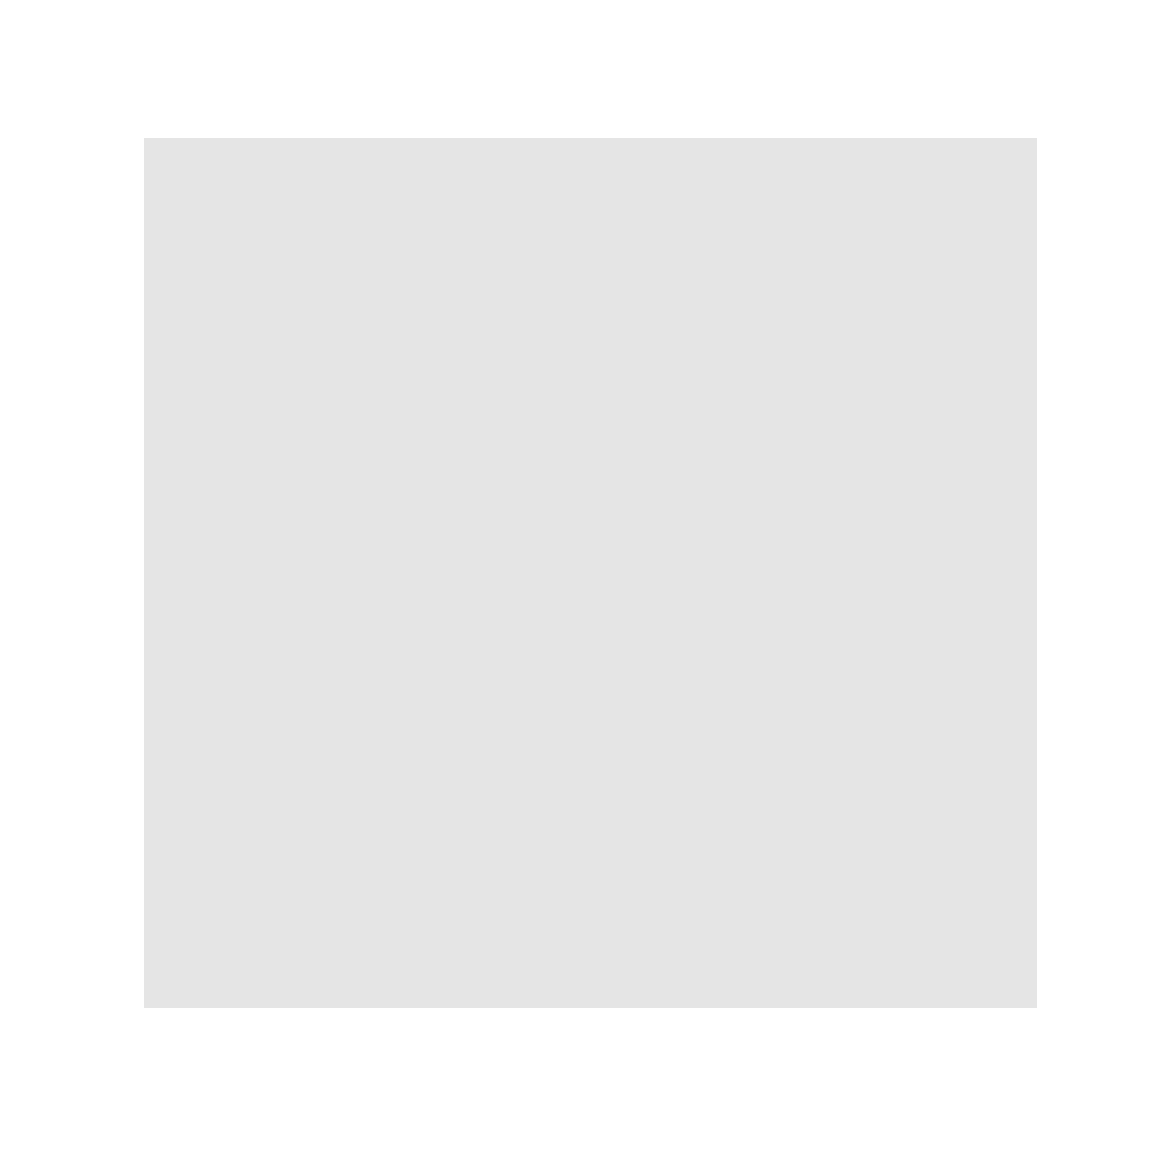

In [35]:
# View history
df = pd.DataFrame(data).T
df

df["steps"]=df.index
plt.figure(figsize=(8,8))
sns.regplot(x="steps", y="reward", data=df, order=1)

# Test

In [ ]:
env_test = PortfolioEnv(
    df=df_test,
    steps=48*7, # run for a week at a time
    scale=True, 
    trading_cost=0.0025, 
    window_length = window_length,
    output_mode='EIIE',
)

In [53]:
start = date(2016, 1, 1)
end = date(2017, 1, 1)
features= ['close', 'high', 'low']
tickers = ['AAPL','A','MSFT','B','C']

env_test = PortfolioEnv(
    start_date=start,
    end_date=end,
    features_list = features,
    tickers_list=tickers,
    scale=True, 
    trading_cost=0.0025, 
    window_length = window_length,
    output_mode='EIIE',
)
# wrap it in a few wrappers
env_test = ConcatStates(env_test)
env_test = SoftmaxActions(env_test)
environment_test = TFOpenAIGymCust('CryptoPortfolioEIIE-v0', env_test)

env.seed(0)

[0]

In [65]:
# Create an agent
agent = PPOAgent(
    states_spec=environment_test.states,
    actions_spec=actions_spec,
    network_spec=network_spec,
)


In [66]:
agent.restore_model('./outputs/tensorforce_PPO_crypto-20180208_17-41')

INFO:tensorflow:Restoring parameters from ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt-12000026


INFO:tensorflow:Restoring parameters from ./outputs/tensorforce_PPO_crypto-20180208_17-41/model.ckpt-12000026


In [52]:
runner_test = Runner(agent=agent, environment=environment_test)

In [76]:
actions_spec

{'max_value': 1.0, 'min_value': 0.0, 'shape': (6,), 'type': 'float'}

In [86]:
np.array([0,0,1,0,0,0]).shape

(6,)

['cash', 'AAPL', 'A', 'MSFT', 'B', 'C']


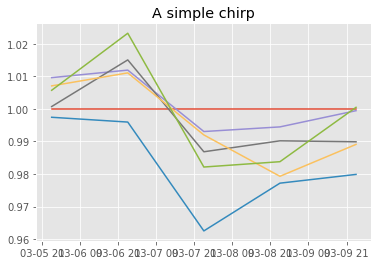

<built-in method index of list object at 0x122930588> DatetimeIndex(['2017-03-06', '2017-03-07', '2017-03-08', '2017-03-09',
               '2017-03-10'],
              dtype='datetime64[ns]', name='date', freq=None)
7 [date
2017-03-06    1.0
2017-03-07    1.0
2017-03-08    1.0
2017-03-09    1.0
2017-03-10    1.0
Name: price_cash, dtype: float64, date
2017-03-06    0.997438
2017-03-07    0.995964
2017-03-08    0.962524
2017-03-09    0.977194
2017-03-10    0.979885
Name: price_AAPL, dtype: float64, date
2017-03-06    1.009615
2017-03-07    1.011930
2017-03-08    0.993056
2017-03-09    0.994480
2017-03-10    0.999466
Name: price_A, dtype: float64, date
2017-03-06    1.000731
2017-03-07    1.015063
2017-03-08    0.986838
2017-03-09    0.990202
2017-03-10    0.989909
Name: price_MSFT, dtype: float64, date
2017-03-06    1.007081
2017-03-07    1.011075
2017-03-08    0.992012
2017-03-09    0.979303
2017-03-10    0.989107
Name: price_B, dtype: float64, date
2017-03-06    1.005731
2017-03-07   

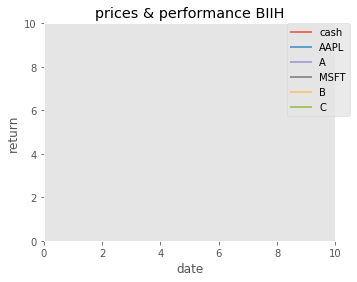

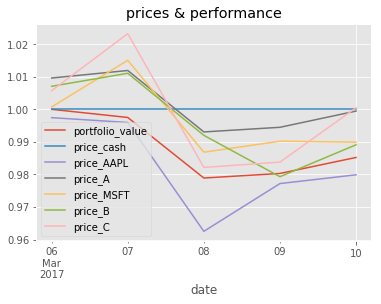

In [73]:
%matplotlib notebook
from rewave.environment.long_portfolio import PortfolioEnv
from rewave.wrappers import SoftmaxActions, ConcatStates
from rewave.callbacks.notebook_plot import LivePlotNotebook

from datetime import date

# params
window_length = 50
cash_bias = 0.0
batch_size=128
import datetime
ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M')
save_path = './outputs/tensorforce_PPO_crypto-%s' % ts
# save_path = './outputs/tensorforce-PPO/tensorforce_PPO_crypto_20171105_06-50-31'
save_path

start = date(2017, 1, 1)
end = date(2018, 1, 1)
features= ['close', 'high', 'low']
tickers = ['AAPL','A','MSFT','B','C']

env_test = PortfolioEnv(
    start_date=start,
    end_date=end,
    features_list = features,
    tickers_list=tickers,
    scale=True, 
    trading_cost=0.0025, 
    window_length = window_length,
    output_mode='EIIE',
)
action = np.array([0,0,1,0,0,0])
env_test.step(action=action)

env_test.step(action=action)

env_test.step(action=action)

env_test.step(action=action)

#env_test.render()
src = env_test.src
sim = env_test.sim
weights = np.clip(action, 0.0, 1.0)
weights /= weights.sum()
    
history, y1, done1 = src._step()
reward, info, done2 = env_test.sim._step(weights, y1)
infos = env_test.infos
df_info = pd.DataFrame(infos)
df_info.index = pd.to_datetime(df_info["date"], unit='s')
df_info

#############
all_assets = ['cash'] + sim.tickers_list
print(all_assets)
x = df_info.index
y_portfolio = df_info["portfolio_value"]
y_assets = [df_info['price_' + name].cumprod()
                    for name in all_assets]
x , y_portfolio, y_assets

import matplotlib.pyplot as plt2

%matplotlib inline
plt2.plot(x, pd.DataFrame(y_assets).T)
plt2.title('A simple chirp')
plt2.show()


#env_test.render()

#list_columns = ['price_' + name for name in all_assets]
#y_assets = df_info[list_columns].cumprod()
        
df_info[['price_A','price_B']]

list_columns = ['price_' + name for name in all_assets]
list_columns, type(list_columns)
#y_assets = df_info[list_columns].cumprod()
print (y_assets.index, y_portfolio.index)

ys =  y_assets + [y_portfolio]
print(len(ys), ys)

x = np.array(x)

fig, ax = plt.subplots(1, 1)

labels = all_assets
colors = [None] * len(all_assets) + ['black']
linestyles=None
ylabel = 'return'
title='nice'
legend_outside=True
for i in range(len(labels)):
    ax.plot(
        [0] * 20,
        label=labels[i],
        alpha=0.75,
        lw=2,
        color=colors[i] if colors else None,
        linestyle=linestyles[i] if linestyles else None,
    )

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel('date')
ax.set_ylabel(ylabel)
ax.grid()
ax.set_title(title)

# give the legend it's own space, the right 20% where it right align left
if legend_outside:
    fig.subplots_adjust(right=0.8)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
else:
    ax.legend()

for i in range(len(ys)-1):
    # update price
    line = ax.lines[i]
    line.set_xdata(x)
    line.set_ydata(ys[i])

fig.canvas.draw()    
#plt.show()


print(len(ys),len(labels),ys[1])
#########
    
list_columns = ['price_' + name for name in all_assets]
list_columns, type(list_columns)
y_assets = df_info[list_columns].cumprod()


plt2.plot(x, pd.concat([y_portfolio, y_assets], axis=1))
plt2.title('prices & performance BIIH')
plt2.labels=all_assets + ["Portfolio"]
plt2.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt2.ylabel='value'

plt2.show()


#liveplot = LivePlotNotebook(labels=y_assets.columns.values)

#pd.concat([y_portfolio, y_assets], axis=1)

#liveplot.update(x, y_assets.as_matrix())

#y_assets.as_matrix()
"""
"""

pd.concat([y_portfolio, y_assets], axis=1).plot(title="prices & performance", legend="true")


In [43]:
def episode_finished(r):
    print("Finished episode {ep} after {ts} timesteps (reward: {reward})".format(ep=r.episode, ts=r.episode_timestep,
                                                                                 reward=r.episode_rewards[-1]))
    return True

In [48]:
episodes=1
#steps=environment_test.gym.env.env.src.steps*episodes
runner_test.run(
    episodes=episodes,
    timesteps=None,
    deterministic=True,
    episode_finished=episode_finished,
)

AttributeError: 'NoneType' object has no attribute 'run'